
# **Preface**

# **Title**

**Prognostic Value of Baseline and Pre-Lymphodepletion PET/CT Imaging in DLBCL Patients Undergoing CAR T-Cell Therapy**

### **Motivation** 

**Chimeric Antigen Receptor (CAR) T-cell therapy has emerged as a transformative treatment modality for hematologic malignancies, demonstrating remarkable efficacy in diffuse large B-cell lymphoma (DLBCL) [1], [2], [3], [4], [5]. However, bridging therapy is frequently required to control disease burden during the manufacturing period before CAR T-cell infusion [1], [6], [7], [8], [9]. One way to measure the efficacy of bridging therapy on CAR T-cell therapy is through 18F-Fluorodeoxyglucose Positron Emission Tomography/Computerized Tomography (18F-FDG PET/CT) imaging. Current literature predominantly focuses on measuring conventional PET metrics such as metabolic active tumor volume (MATV) and standardized uptake value (SUVmax) at single timepoints, rather than employing comprehensive radiomic analysis of dynamic changes [10], [11], [12] . The prognostic value of high-dimensional radiomic features and their temporal evolution (delta radiomics) between baseline and pre-lymphodepletion chemotherapy (pre-LD) scans remains largely unexplored in the CAR T-cell therapy context [11].**

### **Strategic goals**

**We aim to assess whether baseline, pre-LD or delta radiomic profiles (extracted during the bridging period) provide superior prognostic value compared to conventional clinical variables for predicting treatment response, toxicity, progression-free survival, and overall survival.**

**Starting point**

**Current literature predominantly focuses on conventional PET metrics such as metabolic active tumor volume (MATV) and standardized uptake value (SUVmax) at single timepoints, rather than employing comprehensive radiomic analysis of dynamic changes [13]. Preliminary evidence suggests reduced MATV prior to infusion correlates with improved OS (Overall Survival) and TTP (Time To Progression) [12], [14]. Few studies have systematically assessed delta radiomic features, and almost none have explored high-dimensional changes in a CAR T-cell cohort [13], [15]. Bridging strategies (systemic therapy, radiotherapy, or combinations) may influence imaging dynamics, but their detailed prognostic impact remains unclear [16], [17].**

### **Expected results (Hypothesis)**

**We hypothesize that comprehensive delta radiomic analysis will demonstrate enhanced predictive capability compared to conventional single-timepoint metrics.**

### **Purpose of this notebook**

**During this course project, we worked on semi-manually segmenting the lesions using PET/CT scan images, with the help of the lesion report, created by radiologists involved, for each patient.**

**After this stage, we received the clinical data, which includes factors such as: age, gender, dates of important events, etc.**

**In the end, this notebook is dedicated to preprocessing, combining the radiomics data extracted from the images, and the clinical data, and then finally, running suitable analysis on them to test our hypothesis.**

### **Results so far**

Machine Learning–Based Analysis (Logistic Regression and KNN)

The research used machine learning methods to evaluate how clinical and radiomics features predict patient results following CAR T-cell therapy because the study included only 30 patients and contained 170 features. 

In this notebook, we analyzed both logistic regression models and the k-nearest neighbors (KNN) algorithm.

**Logistic Regression Models**

Models combining clinical and radiomics features were assessed employing various logistic regression techniques which do not include any form of penalty, L1 regularisation, L2 regularisation and Elastic Net, with different sets of features. Although results from certain configurations showed moderate accuracy and F1 score along with ROC-AUC value on the test data, the performance was found to be highly variable and was dependent on the chosen feature set as well as the method of regularization.

The model's accuracy on training data was significantly higher than its accuracy on testing data, indicating over-training. In settings where there are a small number of cases and numerous correlated variables, complexity has to be controlled rigorously. This is true even when using the techniques for preventing overfitting mentioned above.

In the analysis of evaluated penalties, a relatively stable performance was observed with the L2 regularisation method. In contrast L1 regularisation, frequently caused the removal of all of the features from the model which resulted in poor predictive performance. For dimensionality reduction L1-based feature selection was effective; however direct use of L1 as the model penalty was too extreme. The results obtained from the logistic regression indicate that the method's predictive ability appears to be weak and heavily reliant on chance rather than a clear underlying pattern.

**K-Nearest Neighbors (KNN) Analysis**

In order to investigate these results in greater detail, a non-parametric KNN classifier was utilised on the identical feature sets. A predictive model derived solely from clinical and pathological parameters was unable to distinguish effectively between patients with good and poor short term prognosis. As in the case with models incorporating delta radiomics features following treatment, these radiomics features after treatment led to models which did not work well. These failed to classify the patients as dead and showed symptoms of overfitting in their results.

Combining the clinical variables with the pre-operative image features that are quantitative enabled the KNN to classify more effectively across the different outcome classes. It appears that standard clinical parameters and information from conventional imaging modalities might fail to capture features such as tumor size, spatial distribution and biological heterogeneity. It may be that characteristics of the tumor reflect its potential for treatment resistance.

It must be borne in mind that these findings should be viewed with caution. The results of the k-nearest neighbours test were highly dependent on which patients were included in the test set. The accuracy and AUC changed significantly with even minor adjustments to the division between the data used to learn and the data used to evaluate the model. Given the experimental nature of this study, the results from the KNN procedure should be regarded as exploratory rather than definitive.

**Overall Interpretation and Limitations**

Results from both clinical evaluation and K nearest neighbours analysis indicate that pre-treatment radiological features were more informative than clinical assessment alone or post treatment imaging. All of the various methods tested suffered from a number of drawbacks, most notably a tendency to be unstable, a susceptibility to overfitting, and a lack of robustness to the manner in which the available data is split.

The research into the methodologies used has shown that small sample sizes and the lack of proper validation are major causes of bias and lack of reproducibility in studies which use machine learning with radiomics [19,20,22]. Due to the current study's combination of high-dimensional feature spaces and a relatively small number of cases, the reliability of any model's performance and its ability to generalise is impaired.

Given that the results are to be considered as exploratory and for the purpose of hypothesis generation rather than being seen as evidence of any reliable predictive capability, Further studies should involve large groups of patients treated at various centres and should also employ more reliable testing methods, such as cross-checking data and checking the findings with data from different sources, in order to more accurately assess the benefits of combining radiomics and machine learning with CAR-T cell therapy.

----

## **1) Import libraries, Data, and preprocessing**

### **1.1) Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

### **1.2) Import Data**

In [2]:
CONFIG_PATH = Path("..") / "config.yaml"  

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)


### **1.3) Delta Radiomics**

In [3]:
def calculate_delta_radiomics(data_folder_path):
    """
    Reads radiomics data from subfolders (Time A and Time B), filters for 'suv2.5' 
    segmentation, calculates the delta (B - A) for numeric features, and stores
    the results in a dictionary per patient.

    Args:
        data_folder_path (str): The path to the main folder containing patient subfolders.

    Returns:
        (pd.DataFrame, pd.DataFrame, pd.DataFrame):
            delta_df: Delta radiomics (B - A), patients as index, features as columns.
            A_df: Radiomics at time A, same shape.
            B_df: Radiomics at time B, same shape.
    """
    all_delta_radiomics = {}
    A_radiomics, B_radiomics = {}, {}

    # 1. Iterate through all items in the main data folder
    for patient_folder_name in os.listdir(data_folder_path):
        patient_path = os.path.join(data_folder_path, patient_folder_name)
        
        # Ensure it is actually a directory (a patient folder)
        if os.path.isdir(patient_path):
            print(f"--- Processing {patient_folder_name} ---")
            
            # Initialize paths for Time A and Time B files
            file_A_path = None
            file_B_path = None
            
            # 2. Find the radiomics files for Time A and Time B in the patient folder
            for filename in os.listdir(patient_path):
                path_excel = os.path.join(patient_path, filename)

                # Assuming filenames contain '_A' or '_B' (case-insensitive) + .xlsx
                upper_name = path_excel.upper()
                if '_A' in upper_name and path_excel.endswith('.xlsx'):
                    file_A_path = path_excel
                elif '_B' in upper_name and path_excel.endswith('.xlsx'):
                    file_B_path = path_excel

            if file_A_path and file_B_path:
                try:
                    # 3. Read and preprocess the data
                    df_A = pd.read_excel(file_A_path)
                    df_B = pd.read_excel(file_B_path)
                    
                    # 4. Filter for the 'suv2.5' segmentation row, take columns from 23 onwards
                    row_A = df_A[df_A['Segmentation'].str.contains('suv2.5')].iloc[0, 23:]
                    row_B = df_B[df_B['Segmentation'].str.contains('suv2.5')].iloc[0, 23:]

                    # 5. Convert to numeric, coercing errors to NaN
                    numeric_A = pd.to_numeric(row_A, errors='coerce')
                    numeric_B = pd.to_numeric(row_B, errors='coerce')

                    # 6. Calculate Delta Radiomics (Time B - Time A)
                    delta_radiomics = numeric_B - numeric_A
                    
                    # Store as dicts, dropping NaNs
                    all_delta_radiomics[patient_folder_name] = delta_radiomics.dropna().to_dict()
                    A_radiomics[patient_folder_name] = numeric_A.dropna().to_dict()
                    B_radiomics[patient_folder_name] = numeric_B.dropna().to_dict()

                    print(f"Successfully calculated radiomics and delta radiomics for {patient_folder_name}.")

                except Exception as e:
                    print(f"Error processing files for {patient_folder_name}: {e}")
            else:
                print(f"Could not find both A and B files in {patient_folder_name}.")

    # Convert dicts to DataFrames (patients = rows, features = columns)
    A_df = pd.DataFrame.from_dict(A_radiomics, orient='index')
    B_df = pd.DataFrame.from_dict(B_radiomics, orient='index')
    delta_df = pd.DataFrame.from_dict(all_delta_radiomics, orient='index')

    return delta_df, A_df, B_df

In [4]:
# Define the path to main data folder

DATA_DIR = config["data"]["root_dir"]

# Run the function
delta_radiomics_results, a_radiomics, b_radiomics = calculate_delta_radiomics(DATA_DIR)

# Print the results for verification
print("\n--- Final Results Summary ---")
for patient, delta_data in delta_radiomics_results.items():
    print(f"\n{patient} Delta Radiomics ({len(delta_data)} features):")
    # Print the first 5 features as an example
    print(dict(list(delta_data.items())[:5]))

--- Processing 005 ---
Successfully calculated radiomics and delta radiomics for 005.
--- Processing 006 ---
Successfully calculated radiomics and delta radiomics for 006.
--- Processing 007 ---
Successfully calculated radiomics and delta radiomics for 007.
--- Processing 008 ---
Successfully calculated radiomics and delta radiomics for 008.
--- Processing 009 ---
Successfully calculated radiomics and delta radiomics for 009.
--- Processing 010 ---
Successfully calculated radiomics and delta radiomics for 010.
--- Processing 011 ---
Successfully calculated radiomics and delta radiomics for 011.
--- Processing 013 ---
Successfully calculated radiomics and delta radiomics for 013.
--- Processing 014 ---
Successfully calculated radiomics and delta radiomics for 014.
--- Processing 015 ---
Successfully calculated radiomics and delta radiomics for 015.
--- Processing 016 ---
Successfully calculated radiomics and delta radiomics for 016.
--- Processing 017 ---
Successfully calculated radiomi

In [5]:
delta_radiomics_results.shape

(31, 99)

In [6]:
# Clean and prepare dataframes
# by dropping columns with any NaN values and resetting index
# to keep only the complete cases (some patients have 99 columns with NaNs, but 43 are always present)
# we'll work with those 43.
for df in [delta_radiomics_results, a_radiomics, b_radiomics]:
    df.dropna(axis=1, how='any', inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'id'}, inplace=True)
    df['id'] = df['id'].astype(int)

In [7]:
# to differentiate the columns of A and B datasets
a_radiomics = a_radiomics.add_suffix('_a')

In [8]:
a_radiomics.head()


,id_a,MeshVolume (cc)_a,Volume (cc)_a,Compactness1_a,Compactness2_a,Elongation_a,Flatness_a,LeastAxisLength_a,MajorAxisLength_a,Maximum2DDiameterColumn_a,...,SUV_StandardDeviation_a,SUV_TotalEnergy_a,SUV_Uniformity_a,SUV_Variance_a,TLG_a,Number of lesions_a,Dmax Patient (mm)_a,Spread Patient (mm)_a,Dmax Bulk (mm)_a,Spread Bulk (mm)_a
0,5,410.103787,398.813580,0.005837,0.012107,0.558487,0.355846,102.570709,288.244831,604.608311,...,4.693224,2.838198e+07,0.995641,22.026354,2795.671489,22.0,1012.265388,12143.739993,634.643836,5391.583970
1,6,382.203626,388.922067,0.009420,0.031529,0.222277,0.119058,75.010564,630.035602,534.767317,...,3.611391,1.899080e+07,1.000000,13.042143,2326.624355,19.0,826.848496,9064.189020,581.042584,6016.069298
2,7,2318.279862,2316.219528,0.001282,0.000584,0.286171,0.198725,162.471469,817.568425,864.561388,...,2.539564,4.722033e+07,0.998794,6.449383,8647.110928,8.0,968.496772,4669.493537,496.134002,2114.161419
3,8,657.198795,662.416920,0.011321,0.045535,0.573857,0.188817,94.938713,502.808344,657.007222,...,1.879892,1.491912e+07,1.000000,3.533992,2886.516585,6.0,919.512055,2912.601228,919.512055,2682.518960
4,9,280.358030,284.356359,0.014593,0.075666,0.134513,0.093095,62.068863,666.725172,495.125230,...,5.240395,2.040936e+07,0.969021,27.461740,1892.885103,8.0,764.874890,3262.263546,753.472897,2944.758813


In [9]:
b_radiomics = b_radiomics.add_suffix('_b')

In [10]:
print(b_radiomics.head())

   id_b  MeshVolume (cc)_b  Volume (cc)_b  Compactness1_b  Compactness2_b  \
0     5         589.782620     601.475560        0.006102        0.013228   
1     6         178.716698     182.407500        0.014339        0.073050   
2     7        1979.423386    2262.660989        0.000776        0.000214   
3     8         525.023235     528.273900        0.014567        0.075396   
4     9         414.394448     419.439240        0.010660        0.040372   

   Elongation_b  Flatness_b  LeastAxisLength_b  MajorAxisLength_b  \
0      0.403919    0.176433         105.019308         595.234636   
1      0.224911    0.121439          75.138425         618.733646   
2      0.357596    0.215124         182.482165         848.265892   
3      0.491120    0.219470          98.223091         447.546283   
4      0.413164    0.203700         140.939516         691.898977   

   Maximum2DDiameterColumn_b  ...  SUV_StandardDeviation_b  SUV_TotalEnergy_b  \
0                 453.607929  ...        

### **1.4) Clinical Data**

In [11]:

clinical_dir = config["clinical"]["root_dir"]      # "D:/DSLS/Omics2/modelling/clinical_data"
clinical_file = config["clinical"]["main_file"]    # "10162025_UMCG_wide_export_Yescarta_infused_for_tFL_study.xlsx"

clinical_path = os.path.join(clinical_dir, clinical_file)
clinic_data = pd.read_excel(clinical_path)


In [12]:
clinic_data.head()

,record_id,medhis_diag_comments,scr_date_tb1stmeeting,scr_sex,scr_sex.factor,scr_age,scr_height,scr_weight,scr_bmi,indication_dis_diagnosis,...,post_cart_ther_spec_2___ne.factor,post_cart_ther_comment_spec,cli_st_lab_date,cli_st_hemoglobin,cli_st_trombocytes,cli_st_leukocytes,cli_st_neutrophils,cli_st_ldh,cli_st_crp,cli_st_ferritin
0,Record ID,Comments,Date 1st tumorboard meeting,Sex,NaN,Age,Height,Weight,BMI (kg/m2),Diagnosis for which there is now a cellular th...,...,NaN,Please specify all subsequent anti-cancer ther...,Date lab results,Hemoglobin in mmol/L,Thrombocytes in 10E9/L,Leukocytes in 10E9/L,Neutrophils in 10E9/L (automated differentiation),LDH in U/L,CRP in mg/L,Ferritin in µg/l
1,FTC-UMCG-0001,splenectomy 2012: total hip links 2015: jich...,2020-05-04,0,Male,68,180,72.6,22,1,...,Unchecked,NaN,2020-04-28,7.1,90,6.3,4.74,169,26,NE
2,FTC-UMCG-0002,> 20 jaar geleden DVT links Longembolie links...,2020-05-07,0,Male,73,190,86,24,2,...,Unchecked,NaN,2020-05-14,"6,4",172,4.3,2.83,NE,47,2847
3,FTC-UMCG-0003,"2019 Nov Grootcellig B-Non-Hodgkin lymfoom,...",2020-05-18,0,Male,59,181,91,28,1,...,Unchecked,Radiotherapy CNS and Korfel 3x response evalua...,2020-05-15,7.4,389,11.9,NE,214,14,1404
4,FTC-UMCG-0004,2015 gehoorverlies 2019 aug: DLBCL ...,2020-05-14,1,Female,61,169,73,26,1,...,Unchecked,NaN,2020-04-21,6.5,159,9.2,6.55,296,3.0,NE


In [13]:
clinic_data.shape

(69, 275)

In [14]:
clinic_data['record_id'].values[:3]

array(['Record ID', 'FTC-UMCG-0001', 'FTC-UMCG-0002'], dtype=object)

In [15]:
# creating a cleaned id column so we can merge later with radiomics data
clinic_data['id_cleaned'] = [value[-3:] for value in clinic_data['record_id'].values]

In [16]:
clinic_data.head()

,record_id,medhis_diag_comments,scr_date_tb1stmeeting,scr_sex,scr_sex.factor,scr_age,scr_height,scr_weight,scr_bmi,indication_dis_diagnosis,...,post_cart_ther_comment_spec,cli_st_lab_date,cli_st_hemoglobin,cli_st_trombocytes,cli_st_leukocytes,cli_st_neutrophils,cli_st_ldh,cli_st_crp,cli_st_ferritin,id_cleaned
0,Record ID,Comments,Date 1st tumorboard meeting,Sex,NaN,Age,Height,Weight,BMI (kg/m2),Diagnosis for which there is now a cellular th...,...,Please specify all subsequent anti-cancer ther...,Date lab results,Hemoglobin in mmol/L,Thrombocytes in 10E9/L,Leukocytes in 10E9/L,Neutrophils in 10E9/L (automated differentiation),LDH in U/L,CRP in mg/L,Ferritin in µg/l,ID
1,FTC-UMCG-0001,splenectomy 2012: total hip links 2015: jich...,2020-05-04,0,Male,68,180,72.6,22,1,...,NaN,2020-04-28,7.1,90,6.3,4.74,169,26,NE,001
2,FTC-UMCG-0002,> 20 jaar geleden DVT links Longembolie links...,2020-05-07,0,Male,73,190,86,24,2,...,NaN,2020-05-14,"6,4",172,4.3,2.83,NE,47,2847,002
3,FTC-UMCG-0003,"2019 Nov Grootcellig B-Non-Hodgkin lymfoom,...",2020-05-18,0,Male,59,181,91,28,1,...,Radiotherapy CNS and Korfel 3x response evalua...,2020-05-15,7.4,389,11.9,NE,214,14,1404,003
4,FTC-UMCG-0004,2015 gehoorverlies 2019 aug: DLBCL ...,2020-05-14,1,Female,61,169,73,26,1,...,NaN,2020-04-21,6.5,159,9.2,6.55,296,3.0,NE,004


In [17]:
clinic_data['id_cleaned'].values

array([' ID', '001', '002', '003', '004', '005', '006', '007', '008',
       '009', '010', '011', '012', '013', '014', '015', '016', '017',
       '018', '019', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '046', '047', '048', '049',
       '050', '051', '052', '053', '054', '055', '060', '061', '064',
       '065', '066', '067', '068', '069', '070', '075', '076', '077',
       '078', '079', '080', '081', '082', '083', '084', '085', '086',
       '087', '088', '089', '090', '096', '104'], dtype=object)

In [18]:
# type conversion to int for merging with radiomics data
patient_ids = clinic_data['id_cleaned'].values[1:].astype(int)


In [19]:
# find patients that are in both datasets
# values starts from 1 to skip the comment row
intercept = [id for id in delta_radiomics_results['id'] if id in patient_ids]

In [20]:
clinic_data['id_cleaned'] = ['ID'] + patient_ids.tolist()

In [21]:
clinic_data_cleaned = clinic_data[clinic_data['id_cleaned'].isin(intercept)]

In [22]:
clinic_data_cleaned.reset_index(drop=True, inplace=True)

In [23]:
clinic_data_cleaned.shape

(30, 276)

**Eventually, we have 30 patients with complete clinical and delta radiomics data to work with.**

**Note:** patient 95 is missing their clinical data. 


In [24]:
# dropping columns with all NaN values
clinic_data_cleaned = clinic_data_cleaned.dropna(axis=1, how='all')

In [25]:
clinic_data_cleaned.shape

(30, 266)

In [26]:
# we don't need factor columns for modelling as they are encoded already
factors = [factor for factor in clinic_data_cleaned.columns if 'factor' in factor]

In [27]:
comments = [comm for comm in clinic_data_cleaned.columns if 'comment' in comm]

In [28]:
comments

['medhis_diag_comments', 'post_cart_ther_comment_spec']

In [29]:
locations = [loc for loc in clinic_data_cleaned.columns if 'loc' in loc]

In [30]:
# these are highly correlated features with bmi
correlated = ['scr_height', 'scr_weight']

* scr_age (continuous) correlates to indication_age_60 (binary), we Keep scr_age (continuous). It retains more information and doesn't arbitrarily cut at 60.  
* indication_ldh_uln: we have the exact value for ldh  
* indication_extran_sites, indication_extran_invol, indication_extranodal_nr	These are highly related. we keep indication_extranodal_nr (exact number). It is the most granular quantitative measure.

In [31]:
indicators = ['indication_ldh_uln','indication_age_60','indication_extran_sites', 'indication_extran_invol']

In [32]:
# cause of death columns are not needed
cause_of_death = [cause for cause in clinic_data_cleaned.columns if '_cause' in cause]

**NOTE:** indication_dis_diagnosis must be one-hot encoded. as the disease is a nominal categorical feature.

In [33]:
disease = pd.get_dummies(clinic_data_cleaned['indication_dis_diagnosis.factor']).astype(int)

In [34]:
disease.head()

,DLBCL,HGBCL DH/TH,HGBCL NOS,tFL
0,1,0,0,0
1,0,0,0,1
2,0,0,1,0
3,1,0,0,0
4,0,0,0,1


In [35]:
drop_columns = cause_of_death + factors + ['record_id','scr_date_tb1stmeeting', 'indication_dis_diagnosis'] + comments  + correlated + indicators
clinic_data_cleaned.drop(columns=drop_columns,inplace=True)

In [36]:
clinic_data_cleaned.shape

(30, 121)

In [37]:
clinic_data_cleaned = pd.concat([clinic_data_cleaned, disease], axis=1)

In [38]:
# replacing 'NE' with NaN to create valid missing values
clinic_data_cleaned.replace({'NE': np.nan}, inplace=True)

In [39]:
clinic_data_cleaned.describe()

,id_cleaned,DLBCL,HGBCL DH/TH,HGBCL NOS,tFL
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,31.366667,0.366667,0.100000,0.100000,0.433333
std,22.404561,0.490133,0.305129,0.305129,0.504007
min,5.000000,0.000000,0.000000,0.000000,0.000000
25%,13.250000,0.000000,0.000000,0.000000,0.000000
50%,23.500000,0.000000,0.000000,0.000000,0.000000
75%,49.500000,1.000000,0.000000,0.000000,1.000000
max,77.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
nans = clinic_data_cleaned.isna().sum().sort_values(ascending=False)

In [41]:
# columns with more than 12 nans, which is half the data for the patients we have
nans[nans > 12]

post_car_ther_other                           29
surv_death_contrib_other                      29
indication_dis_lymsubtype_cns_localization    29
indication_dis_lymsubtype_cns_onset           29
surv_death_contrib_infect                     29
tr_car_bridg_reg_oth                          28
tr_car_preaph_bridg_type                      28
indication_extranodal_nr                      23
total_num_priortherapylines_fl                18
ae_summ_crs_start_gr2                         18
post_cart_ther_startdate                      17
ae_summ_icans_start_gr2                       16
surv_death_date                               14
ae_summ_icans_highestgrade_v2                 14
ae_summ_icans_stop_v2                         14
ae_summ_icans_start_v2                        14
ae_summ_icans_res_v2                          14
surv_prog_date                                13
cli_st_neutrophils                            13
dtype: int64

In [42]:
# droping columns with more than half nans
drop_nans = nans[nans >= clinic_data_cleaned.shape[0]/2].index

In [43]:
clinic_data_cleaned = clinic_data_cleaned.drop(columns=drop_nans)

In [44]:
clinic_data_cleaned.shape

(30, 113)

In [45]:
# Assuming clinic_data_filtered is the DataFrame you want to convert
date_columns = [date for date in clinic_data_cleaned.columns if ('date' in date) or ('start' in date) or ('stop' in date)]
# 1. Use convert_dtypes() for general automatic inference
# This function automatically converts to best possible dtypes (e.g., object to string, int64 to Int64, float64 to Float64)
# It's particularly useful for handling missing values using pandas' nullable dtypes (e.g., pd.NA).
print("Applying general type conversion...")

# 2. Force remaining object columns that look like numbers to numeric
for col in clinic_data_cleaned.columns:
        if col not in date_columns:
            # Attempt to convert to numeric.
            # this is to fix a typo in columns where , is used instead of .
            if clinic_data_cleaned[col].dtype == 'object':
                clinic_data_cleaned[col] = pd.to_numeric(clinic_data_cleaned[col].str.replace(',','.'), errors='raise')
        else: 
            clinic_data_cleaned[col] = pd.to_datetime(clinic_data_cleaned[col], errors='coerce')
        
print("\nAutomatic type conversion complete.")

Applying general type conversion...

Automatic type conversion complete.


In [46]:
variances = clinic_data_cleaned.select_dtypes(include=np.number).var().sort_values()

In [47]:
# zero variance columns are not useful for modelling so I am dropping them
zero_var = variances[variances == 0].index

In [48]:
clinic_data_cleaned = clinic_data_cleaned.drop(columns=zero_var)

In [49]:
clinic_data_cleaned.shape

(30, 71)

In [50]:
# Impute missing values with the median for numeric columns
for col in clinic_data_cleaned.select_dtypes(include=np.number).columns:
    median_value = clinic_data_cleaned[col].median()
    clinic_data_cleaned[col].fillna(median_value, inplace=True)

In [51]:
clinic_data_cleaned.isna().sum().sort_values(ascending=False)

ae_summ_icans_start_v2           14
ae_summ_icans_stop_v2            14
surv_death_date                  14
surv_prog_date                   13
ae_summ_crs_start_v2              3
                                 ..
indication_dis_lymsubtype_cns     0
indication_res_last_ther_spec     0
indication_res_last_ther          0
indication_sec_refr               0
tFL                               0
Length: 71, dtype: int64

In [52]:
# there are date related column that still have nans, but we will not use them for ml modelling
date_columns = ['ae_summ_icans_stop_v2','ae_summ_icans_start_v2', 
                'surv_death_date',
                'surv_date',
                'surv_time_bestresponse_car', 
                'surv_prog_after_car',
                'surv_prog_date',
                'ae_summ_crs_start_v2', 'ae_summ_crs_stop_v2',
                'tr_car_ld_start',
                'cli_st_lab_date']
clinic_data_cleaned.drop(columns=date_columns, inplace=True)



In [53]:
# we also don't need the remaining date columns for modelling
date_columns = [col for col in clinic_data_cleaned.columns if 'date' in col]

In [54]:
clinic_data_cleaned.drop(columns= date_columns, inplace=True)

In [55]:
clinic_data_cleaned.isna().sum().sum() # confirming no nans remain

0

In [56]:
clinic_data_cleaned.shape

(30, 55)

In [57]:
clinic_data_cleaned.columns

Index(['scr_sex', 'scr_age', 'scr_bmi',
       'total_num_priortherapylines_aggressive', 'indication_priorsct',
       'indication_whops', 'indication_bulkydisease', 'indication_stage',
       'indication_extran_site_loc___1', 'indication_extran_site_loc___2',
       'indication_extran_site_loc___5', 'indication_extran_site_loc___7',
       'indication_extran_site_loc___9', 'indication_extran_site_loc___11',
       'indication_extran_site_loc___13', 'indication_extran_site_loc___14',
       'indication_extran_site_loc___15', 'indication_extran_site_loc___16',
       'indication_extran_site_loc___20', 'indication_pri_refr',
       'indication_sec_refr', 'indication_res_last_ther',
       'indication_res_last_ther_spec', 'indication_dis_lymsubtype_cns',
       'tr_car_preaph_br', 'tr_car_preaph_bridg_reg___8', 'tr_car_br',
       'tr_car_bridg_type', 'tr_car_bridg_reg___3', 'tr_car_bridg_reg___7',
       'tr_car_bridg_reg___8', 'tr_car_bridg_reg___12', 'ae_summ_crs_v2',
       'ae_summ_h

In [58]:
# in the dataset, it's the opposite of what we want: 1 means event occurred (death), 0 means censored (alive)
# so we need to invert it
clinic_data_cleaned['surv_status'] = 1 - clinic_data_cleaned['surv_status']

In [59]:
# all the clinical and delta radiomics and single point radiomics data combined
modelling_data = pd.concat([clinic_data_cleaned, delta_radiomics_results, a_radiomics, b_radiomics], axis=1)

In [60]:
modelling_data.head()

,scr_sex,scr_age,scr_bmi,total_num_priortherapylines_aggressive,indication_priorsct,indication_whops,indication_bulkydisease,indication_stage,indication_extran_site_loc___1,indication_extran_site_loc___2,...,SUV_StandardDeviation_b,SUV_TotalEnergy_b,SUV_Uniformity_b,SUV_Variance_b,TLG_b,Number of lesions_b,Dmax Patient (mm)_b,Spread Patient (mm)_b,Dmax Bulk (mm)_b,Spread Bulk (mm)_b
0,0.0,62.0,19.0,2.0,4.0,0.0,0.0,4.0,0.0,1.0,...,4.557200,3.801028e+07,0.995566,20.768074,3917.771002,35.0,1196.879586,22496.243660,795.620306,11241.343898
1,1.0,58.0,19.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,...,1.385548,1.335473e+06,1.000000,1.919742,423.940616,20.0,1374.014576,16735.852000,935.974729,7738.145091
2,0.0,58.0,30.0,2.0,4.0,0.0,0.0,4.0,0.0,0.0,...,3.255284,5.878635e+07,0.996676,10.596874,8874.764809,11.0,1091.509116,6925.147632,626.585808,3097.299280
3,1.0,72.0,21.0,2.0,4.0,0.0,0.0,4.0,0.0,0.0,...,1.118203,4.936741e+06,1.000000,1.250378,1502.998388,6.0,1315.665591,4304.968469,937.066016,2123.989264
4,0.0,48.0,31.0,2.0,4.0,0.0,0.0,4.0,0.0,0.0,...,7.615255,3.941506e+07,0.904695,57.992107,2515.891962,12.0,1317.910694,7968.471879,780.420733,3480.583802


In [61]:
modelling_data.shape

(31, 187)

-----

### **1.5) Data Prepration**

In [62]:
# we need to drop the last row, as the patient's clinical data is not available
modelling_data = modelling_data.iloc[:-1,:]

In [63]:
only_clinic = clinic_data_cleaned.drop(columns=['id_cleaned','surv_status'])

In [64]:
no_delta_radiomics = pd.concat([clinic_data_cleaned, a_radiomics, b_radiomics], axis=1)
# to eliminate patient 95 who there's no clinical data for
no_delta_radiomics = no_delta_radiomics.iloc[:-1,:]

In [65]:
X_with_delta = modelling_data.drop(columns=['id_a','id_b','id_cleaned','id','surv_status']) 

X_without_delta = no_delta_radiomics.drop(columns=['id_a','id_b','id_cleaned','surv_status'])

In [66]:
X_with_a_radiomics = pd.concat([only_clinic, a_radiomics], axis=1).iloc[:-1,:]

In [67]:
X_with_b_radiomics = pd.concat([only_clinic, b_radiomics], axis=1).iloc[:-1,:]

In [68]:
target_variable = "surv_status"

In [69]:
y = modelling_data[target_variable]



 **Machine Learning Modeling**

### **Objective:**
To evaluate the predictive value of different feature combinations for patient survival after CAR T-cell therapy.

### **Four Dataset Configurations:**

We test four different feature combinations to understand which data contributes most to prediction:

#### **Dataset 0: Clinical Features Only (Baseline)**
- **Features:** Clinical data only (demographics, lab values, treatment history)
- **Purpose:** Baseline model to compare against
- **Example features:** Age, BMI, leukocytes, CRP, ferritin, bridging therapy

#### **Dataset 1: Clinical + Point A Radiomics**
- **Features:** Clinical + radiomics from baseline PET scan (before treatment)
- **Purpose:** Does baseline tumor imaging improve prediction?
- **Additional features:** Radiomics features from initial scan

#### **Dataset 2: Clinical + Point B Radiomics**
- **Features:** Clinical + radiomics from post-treatment PET scan
- **Purpose:** Does post-treatment imaging improve prediction?
- **Additional features:** Radiomics features from follow-up scan

#### **Dataset 3: Clinical + Delta Radiomics (Full Model)**
- **Features:** Clinical + change in radiomics between scans
- **Purpose:** Does tumor response (imaging change) improve prediction?
- **Additional features:** Delta radiomics (Point B - Point A)

### **Analysis Plan:**
1. Train models on each dataset configuration
2. Compare performance across configurations
3. Identify which features add most value
4. Select best model for clinical use



### **1.6) Prepare 4 datasets**

In [70]:

print("\n" + "="*70)
print("PREPARING DATA")
print("="*70)

y = modelling_data["surv_status"]

X0_clinical_only  = only_clinic.copy()
X1_clinical_A     = X_with_a_radiomics.copy()
X2_clinical_B     = X_with_b_radiomics.copy()
X3_clinical_delta = X_with_delta.copy()

datasets = [
    ("X0: Clinical Only", X0_clinical_only),
    ("X1: Clinical + A Radiomics", X1_clinical_A),
    ("X2: Clinical + B Radiomics", X2_clinical_B),
    ("X3: Clinical + Delta Radiomics", X3_clinical_delta),
]


PREPARING DATA


-----

## **2. KNN Model**

### **Methodology**

In this section, a k-nearest neighbors (KNN) classifier with comprehensive pipeline 
optimization is used to investigate whether clinical and radiomics features can 
predict survival after CAR T-cell therapy. To ensure methodological rigor and 
prevent data leakage, all preprocessing steps—including imputation, feature 
selection, and scaling—were performed within a scikit-learn Pipeline, ensuring 
that transformations are fit exclusively on training data.

**Grid Search and Feature Selection Strategy:**

A grid search with 3-fold stratified cross-validation is performed to optimize 
both the KNN hyperparameters and the feature selection method simultaneously. 

**The search space included:**

  • k (number of neighbors): [3, 5, 7, 9, 11]
  • Feature selection methods: 
    - None (no feature selection)
    - L1 regularization (LogisticRegression with L1 penalty, C ∈ {0.1, 0.5, 1.0})
    - KBest (SelectKBest with f_classif, k ∈ {5, 10, 15})
  • Total combinations tested: 35 per dataset

This approach allowes the pipeline to automatically determine not only the optimal number of neighbors but also whether feature selection was beneficial and, if so, 
which method and parameters performed best on the training data.

**Four different feature configurations are evaluated:**

  • X0: Clinical data alone (53 features)

  • X1: Clinical + pre-treatment radiomics (97 features)

  • X2: Clinical + post-treatment radiomics (97 features)
  
  • X3: Clinical + delta radiomics (182 features)

### **2.1) Import libraries**

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)


### **2.3) Custom Feature Selector (Pipeline-compatible)**

In [72]:

class L1FeatureSelector(BaseEstimator, TransformerMixin):
    """L1-based feature selection using Logistic Regression"""
    
    def __init__(self, C=1.0, threshold=1e-5):
        self.C = C
        self.threshold = threshold
        self.selector = None
        self.support_ = None
        
    def fit(self, X, y):
        # Train L1 logistic regression
        self.selector = LogisticRegression(
            penalty='l1', C=self.C, solver='liblinear',
            max_iter=1000, random_state=42
        )
        self.selector.fit(X, y)
        
        # Select features with non-zero coefficients
        self.support_ = np.abs(self.selector.coef_[0]) > self.threshold
        
        return self
    
    def transform(self, X):
        return X[:, self.support_]
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.arange(np.sum(self.support_))
        return np.array(input_features)[self.support_]


class KBestFeatureSelector(BaseEstimator, TransformerMixin):
    """KBest feature selection wrapper"""
    
    def __init__(self, k=10):
        self.k = k
        self.selector = None
        
    def fit(self, X, y):
        self.selector = SelectKBest(f_classif, k=min(self.k, X.shape[1]))
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return self.selector.get_feature_names_out(input_features)


class NoOpTransformer(BaseEstimator, TransformerMixin):
    """Pass-through transformer (no feature selection)"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.arange(X.shape[1]) if hasattr(self, 'X') else None
        return input_features



### **2.4) Main Analysis Function**

In [73]:
def knn_pipeline_analysis(X, y, dataset_name, 
                          use_gridsearch=True,
                          test_size=0.2, 
                          random_state=42):
    """
    Complete KNN analysis with proper Pipeline (NO DATA LEAKAGE).
    
    Pipeline: Imputer → FeatureSelector → Scaler → KNN
    
    Features:
    - GridSearch for k + feature selection method
    - L1, KBest, or No feature selection
    - All metrics and visualizations
    
    Parameters:
    -----------
    X : DataFrame - Features (already OneHot encoded)
    y : Series - Target variable
    dataset_name : str - Dataset name
    use_gridsearch : bool - Use GridSearchCV or simple training
    test_size : float - Test set proportion
    random_state : int - Random seed
    
    Returns:
    --------
    dict - Complete results
    """
    
    print("\n" + "="*80)
    print(f"  KNN PIPELINE ANALYSIS: {dataset_name}")
    print("="*80)
    print(f"  Samples: {X.shape[0]}, Features: {X.shape[1]}")
    
    # Convert to numpy array
    X_np = X.values if hasattr(X, 'values') else X
    
    # =========================================================================
    # Step 1: Train-Test Split
    # =========================================================================
    X_train, X_test, y_train, y_test = train_test_split(
        X_np, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    train_counts = pd.Series(y_train).value_counts()
    test_counts = pd.Series(y_test).value_counts()
    
    print(f"\n   Split: Train={X_train.shape[0]}, Test={X_test.shape[0]}")
    print(f"     Train: {train_counts[0]} survived, {train_counts[1]} died")
    print(f"     Test:  {test_counts[0]} survived, {test_counts[1]} died")
    
    # =========================================================================
    # Step 2: Build Pipeline
    # =========================================================================
    
    if use_gridsearch:
        print(f"\n   Running GridSearchCV with Pipeline...")
        
        # Build pipeline with placeholder
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('selector', NoOpTransformer()),  # Will be replaced
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(algorithm='brute', n_jobs=1))
        ])
        
        # Parameter grid
        param_grid = {
            'selector': [
                NoOpTransformer(),
                L1FeatureSelector(C=0.1),
                L1FeatureSelector(C=0.5),
                L1FeatureSelector(C=1.0),
                KBestFeatureSelector(k=5),
                KBestFeatureSelector(k=10),
                KBestFeatureSelector(k=15),
            ],
            'knn__n_neighbors': [3, 5, 7, 9, 11]
        }
        
        total_combinations = len(param_grid['selector']) * len(param_grid['knn__n_neighbors'])
        print(f"     Testing {total_combinations} combinations...")
        
        # GridSearchCV
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=1,  # Single thread to avoid OpenBLAS issues
            verbose=1,
            return_train_score=True
        )
        
        # Fit
        grid_search.fit(X_train, y_train)
        
        # Best model
        best_pipeline = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        print(f"\n   GridSearch Complete!")
        print(f"\n   BEST PARAMETERS:")
        
        # Extract readable info
        selector_obj = best_params['selector']
        if isinstance(selector_obj, L1FeatureSelector):
            method = 'L1'
            detail = f"C={selector_obj.C}"
        elif isinstance(selector_obj, KBestFeatureSelector):
            method = 'KBest'
            detail = f"k={selector_obj.k}"
        else:
            method = 'None'
            detail = ''
        
        k = best_params['knn__n_neighbors']
        
        print(f"     k = {k}")
        print(f"     Method = {method}")
        if detail:
            print(f"     Params = {detail}")
        
        # Count selected features
        if hasattr(best_pipeline.named_steps['selector'], 'support_'):
            n_selected = np.sum(best_pipeline.named_steps['selector'].support_)
            print(f"     Features: {X.shape[1]} → {n_selected}")
        elif hasattr(best_pipeline.named_steps['selector'], 'selector'):
            if hasattr(best_pipeline.named_steps['selector'].selector, 'k'):
                n_selected = best_pipeline.named_steps['selector'].selector.k
                print(f"     Features: {X.shape[1]} → {n_selected}")
        
        print(f"     CV Accuracy: {best_score:.3f}")
        
        best_params_clean = {
            'k': k,
            'method': method,
            'detail': detail
        }
        
    else:
        # Simple pipeline without GridSearch
        print(f"\n   Training simple Pipeline (k=5, no selection)...")
        
        best_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('selector', NoOpTransformer()),
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=5, algorithm='brute', n_jobs=1))
        ])
        
        best_pipeline.fit(X_train, y_train)
        
        best_params_clean = {'k': 5, 'method': 'None', 'detail': ''}
        grid_search = None
    
    # =========================================================================
    # Step 3: Predictions
    # =========================================================================
    print(f"\n   Making predictions...")
    
    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]
    
    # =========================================================================
    # Step 4: Metrics
    # =========================================================================
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"\n   Test Performance:")
    print(f"     Accuracy: {acc:.3f}, AUC: {roc_auc:.3f}, F1: {f1:.3f}")
    
    print(f"\n   Classification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=['Survived', 'Died'],
                                zero_division=0))
    
    # =========================================================================
    # Step 5: Visualizations
    # =========================================================================
    plot_individual_pipeline(
        y_test, y_pred, y_proba, dataset_name,
        best_params_clean, acc, roc_auc, f1,
        train_counts, test_counts
    )
    
    return {
        'name': dataset_name,
        'pipeline': best_pipeline,
        'best_params': best_params_clean,
        'grid_search': grid_search,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'metrics': {
            'accuracy': acc,
            'balanced_acc': bal_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        },
        'cm': confusion_matrix(y_test, y_pred)
    }


### **2.5) Visulization Functions**

In [74]:

def plot_individual_pipeline(y_test, y_pred, y_proba, name, best_params,
                             acc, auc, f1, train_counts, test_counts):
    """Individual dataset visualization with Pipeline info"""
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(f'KNN Pipeline: {name}', fontsize=14, fontweight='bold')
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Survived', 'Died']).plot(
        ax=axes[0,0], cmap='Blues', values_format='d'
    )
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].grid(False)
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[0,1].plot(fpr, tpr, lw=2.5, label=f'AUC={auc:.3f}', color='darkorange')
    axes[0,1].plot([0,1], [0,1], 'k--', lw=1)
    axes[0,1].set_xlabel('FPR')
    axes[0,1].set_ylabel('TPR')
    axes[0,1].set_title('ROC Curve')
    axes[0,1].legend()
    axes[0,1].grid(alpha=0.3)
    
    # 3. Pie Chart
    class_counts = pd.Series(y_test).value_counts()
    axes[0,2].pie(class_counts.values, 
                  labels=['Survived', 'Died'],
                  autopct='%1.1f%%',
                  colors=['skyblue', 'coral'],
                  startangle=90)
    axes[0,2].set_title('Test Distribution')
    
    # 4. Performance Metrics
    metrics = {'Accuracy': acc, 'F1-Score': f1, 'ROC-AUC': auc}
    axes[1,0].barh(list(metrics.keys()), list(metrics.values()),
                   color='steelblue', alpha=0.7, edgecolor='black')
    axes[1,0].set_xlim(0, 1.05)
    axes[1,0].set_xlabel('Score')
    axes[1,0].set_title('Performance Metrics')
    axes[1,0].grid(axis='x', alpha=0.3)
    for i, (metric, value) in enumerate(metrics.items()):
        axes[1,0].text(value + 0.02, i, f'{value:.3f}', 
                      va='center', fontweight='bold')
    
    # 5. Class Distribution
    x_pos = np.arange(2)
    width = 0.35
    axes[1,1].bar(x_pos - width/2, [train_counts[0], train_counts[1]], 
                  width, label='Train', alpha=0.8, color='skyblue')
    axes[1,1].bar(x_pos + width/2, [test_counts[0], test_counts[1]], 
                  width, label='Test', alpha=0.8, color='coral')
    axes[1,1].set_xlabel('Class')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_title('Class Distribution')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels(['Survived', 'Died'])
    axes[1,1].legend()
    axes[1,1].grid(axis='y', alpha=0.3)
    
    # 6. Pipeline Info
    axes[1,2].axis('off')
    info_text = "Pipeline Configuration:\n\n"
    info_text += "Imputer → Selector → Scaler → KNN\n\n"
    info_text += f"k: {best_params['k']}\n"
    info_text += f"Method: {best_params['method']}\n"
    if best_params['detail']:
        info_text += f"{best_params['detail']}\n"
    info_text += f"\nAcc: {acc:.3f}\nAUC: {auc:.3f}"
    
    axes[1,2].text(0.1, 0.5, info_text, 
                  fontsize=10, family='monospace',
                  verticalalignment='center',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1,2].set_title('Model Info')
    
    plt.tight_layout()
    plt.show()


### **2.6) Plot Comparison Pipeline**

In [75]:
def plot_comparison_pipeline(all_results):
    """Comparison visualization for all datasets"""
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    fig.suptitle('KNN Pipeline: All Datasets Comparison', 
                 fontsize=16, fontweight='bold')
    
    names = [r['name'] for r in all_results]
    short_names = ['X0:Clin', 'X1:+A', 'X2:+B', 'X3:+Δ']
    
    # 1. Accuracy
    ax1 = fig.add_subplot(gs[0, 0])
    accs = [r['metrics']['accuracy'] for r in all_results]
    bars = ax1.bar(short_names, accs, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Accuracy', fontweight='bold')
    ax1.set_title('Accuracy')
    ax1.set_ylim(0, 1.05)
    ax1.grid(axis='y', alpha=0.3)
    for bar, acc in zip(bars, accs):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{acc:.3f}', ha='center', fontweight='bold', fontsize=9)
    
    # 2. AUC
    ax2 = fig.add_subplot(gs[0, 1])
    aucs = [r['metrics']['roc_auc'] for r in all_results]
    bars = ax2.bar(short_names, aucs, color='darkorange', alpha=0.7, edgecolor='black')
    ax2.set_ylabel('AUC', fontweight='bold')
    ax2.set_title('ROC-AUC')
    ax2.set_ylim(0, 1.05)
    ax2.grid(axis='y', alpha=0.3)
    for bar, auc in zip(bars, aucs):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{auc:.3f}', ha='center', fontweight='bold', fontsize=9)
    
    # 3. F1
    ax3 = fig.add_subplot(gs[0, 2])
    f1s = [r['metrics']['f1'] for r in all_results]
    bars = ax3.bar(short_names, f1s, color='seagreen', alpha=0.7, edgecolor='black')
    ax3.set_ylabel('F1', fontweight='bold')
    ax3.set_title('F1-Score')
    ax3.set_ylim(0, 1.05)
    ax3.grid(axis='y', alpha=0.3)
    for bar, f1 in zip(bars, f1s):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{f1:.3f}', ha='center', fontweight='bold', fontsize=9)
    
    # 4. ROC Overlay
    ax4 = fig.add_subplot(gs[1, :2])
    colors = ['blue', 'green', 'red', 'purple']
    for i, result in enumerate(all_results):
        fpr, tpr, _ = roc_curve(result['y_test'], result['y_proba'])
        ax4.plot(fpr, tpr, lw=2.5, color=colors[i], 
                label=f"{short_names[i]} (AUC={result['metrics']['roc_auc']:.3f})")
    ax4.plot([0,1], [0,1], 'k--', lw=1.5, label='Random')
    ax4.set_xlabel('FPR', fontweight='bold')
    ax4.set_ylabel('TPR', fontweight='bold')
    ax4.set_title('ROC Curves - All Datasets', fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3)
    
    # 5. Pipeline Summary
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('off')
    ax5.text(0.5, 0.95, 'Pipeline Info', ha='center', fontsize=11, 
            fontweight='bold', transform=ax5.transAxes)
    
    for i, result in enumerate(all_results):
        y_pos = 0.80 - i*0.18
        params = result['best_params']
        text = f"{short_names[i]}: k={params['k']}, {params['method']}"
        ax5.text(0.05, y_pos, text, fontsize=8, 
                transform=ax5.transAxes, family='monospace')
    
    # 6. Heatmap
    ax6 = fig.add_subplot(gs[2, :])
    metrics_names = ['Acc', 'Bal-Acc', 'Prec', 'Rec', 'F1', 'AUC']
    heatmap_data = []
    for r in all_results:
        m = r['metrics']
        row = [m['accuracy'], m['balanced_acc'], m['precision'], 
               m['recall'], m['f1'], m['roc_auc']]
        heatmap_data.append(row)
    heatmap_data = np.array(heatmap_data)
    
    im = ax6.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax6.set_xticks(np.arange(len(metrics_names)))
    ax6.set_yticks(np.arange(len(short_names)))
    ax6.set_xticklabels(metrics_names)
    ax6.set_yticklabels(short_names)
    
    for i in range(len(short_names)):
        for j in range(len(metrics_names)):
            ax6.text(j, i, f'{heatmap_data[i, j]:.3f}',
                    ha="center", va="center", color="black", 
                    fontweight='bold', fontsize=9)
    
    ax6.set_title('All Metrics Heatmap', fontweight='bold', pad=10)
    cbar = plt.colorbar(im, ax=ax6, orientation='horizontal', pad=0.1, aspect=30)
    cbar.set_label('Score', fontweight='bold')
    
    plt.show()


### **2.7) Create_summary_table**

In [76]:

def create_summary_table(all_results):
    """Summary table"""
    print("\n" + "="*100)
    print("SUMMARY: KNN PIPELINE WITH GRIDSEARCH & FEATURE SELECTION")
    print("="*100)
    print(f"{'Dataset':<35} {'k':<5} {'Method':<10} {'Acc':<8} {'AUC':<8} {'F1':<8}")
    print("-"*100)
    
    for r in all_results:
        name = r['name']
        params = r['best_params']
        m = r['metrics']
        print(f"{name:<35} {params['k']:<5} {params['method']:<10} "
              f"{m['accuracy']:<8.3f} {m['roc_auc']:<8.3f} {m['f1']:<8.3f}")
    
    print("="*100)
    
    best_idx = np.argmax([r['metrics']['roc_auc'] for r in all_results])
    print(f"\n BEST: {all_results[best_idx]['name']}")
    print(f"   AUC: {all_results[best_idx]['metrics']['roc_auc']:.3f}")
    print(f"   Pipeline: k={all_results[best_idx]['best_params']['k']}, "
          f"{all_results[best_idx]['best_params']['method']}")

print("""

═══════════════════════════════════════════════════════════════════════════
                            PIPELINE STRUCTURE
═══════════════════════════════════════════════════════════════════════════
Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('selector', FeatureSelector()),  # L1, KBest, or None
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

 NO DATA LEAKAGE - All preprocessing in Pipeline!
 GridSearch on full Pipeline
 Feature Selection (L1 + KBest)
 Comprehensive Visualizations
═══════════════════════════════════════════════════════════════════════════
""")



═══════════════════════════════════════════════════════════════════════════
                            PIPELINE STRUCTURE
═══════════════════════════════════════════════════════════════════════════
Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('selector', FeatureSelector()),  # L1, KBest, or None
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

 NO DATA LEAKAGE - All preprocessing in Pipeline!
 GridSearch on full Pipeline
 Feature Selection (L1 + KBest)
 Comprehensive Visualizations
═══════════════════════════════════════════════════════════════════════════



### **2.8) Running KNN on All Datasets**


  KNN PIPELINE ANALYSIS: X0: Clinical Only
  Samples: 30, Features: 53

   Split: Train=24, Test=6
     Train: 11 survived, 13 died
     Test:  3 survived, 3 died

   Running GridSearchCV with Pipeline...
     Testing 35 combinations...
Fitting 3 folds for each of 35 candidates, totalling 105 fits

   GridSearch Complete!

   BEST PARAMETERS:
     k = 9
     Method = None
     CV Accuracy: 0.625

   Making predictions...

   Test Performance:
     Accuracy: 0.500, AUC: 0.444, F1: 0.400

   Classification Report:
              precision    recall  f1-score   support

    Survived       0.50      0.67      0.57         3
        Died       0.50      0.33      0.40         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6



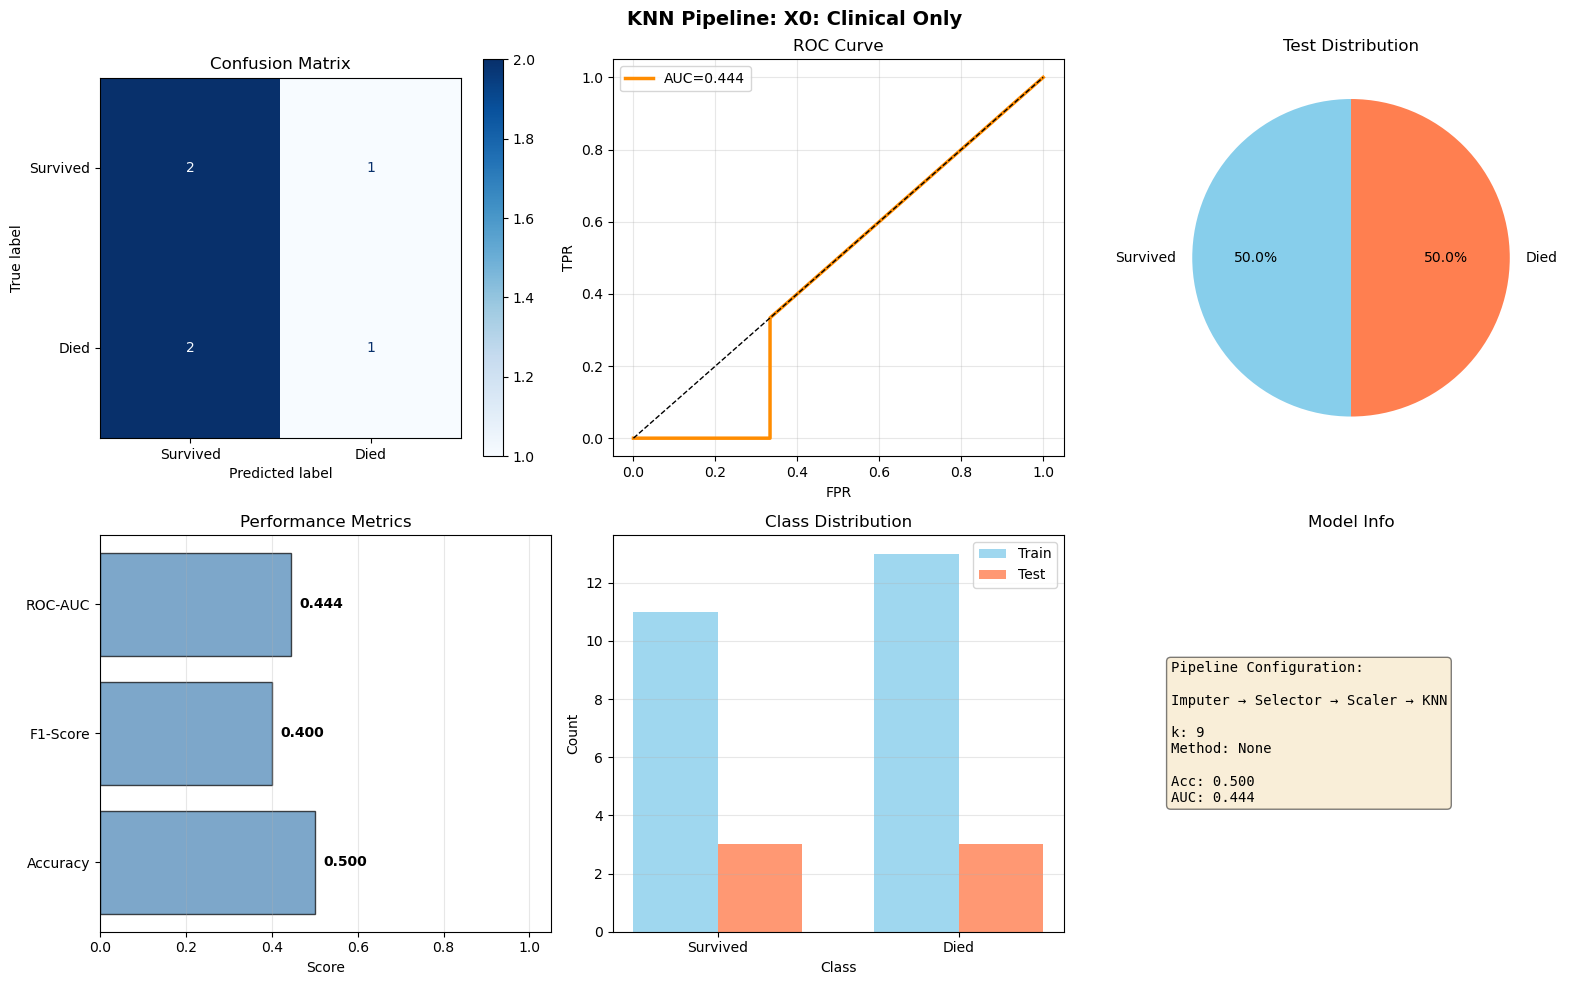


  KNN PIPELINE ANALYSIS: X1: Clinical + A Radiomics
  Samples: 30, Features: 97

   Split: Train=24, Test=6
     Train: 11 survived, 13 died
     Test:  3 survived, 3 died

   Running GridSearchCV with Pipeline...
     Testing 35 combinations...
Fitting 3 folds for each of 35 candidates, totalling 105 fits

   GridSearch Complete!

   BEST PARAMETERS:
     k = 5
     Method = L1
     Params = C=0.1
     Features: 97 → 15
     CV Accuracy: 0.667

   Making predictions...

   Test Performance:
     Accuracy: 0.833, AUC: 0.889, F1: 0.857

   Classification Report:
              precision    recall  f1-score   support

    Survived       1.00      0.67      0.80         3
        Died       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



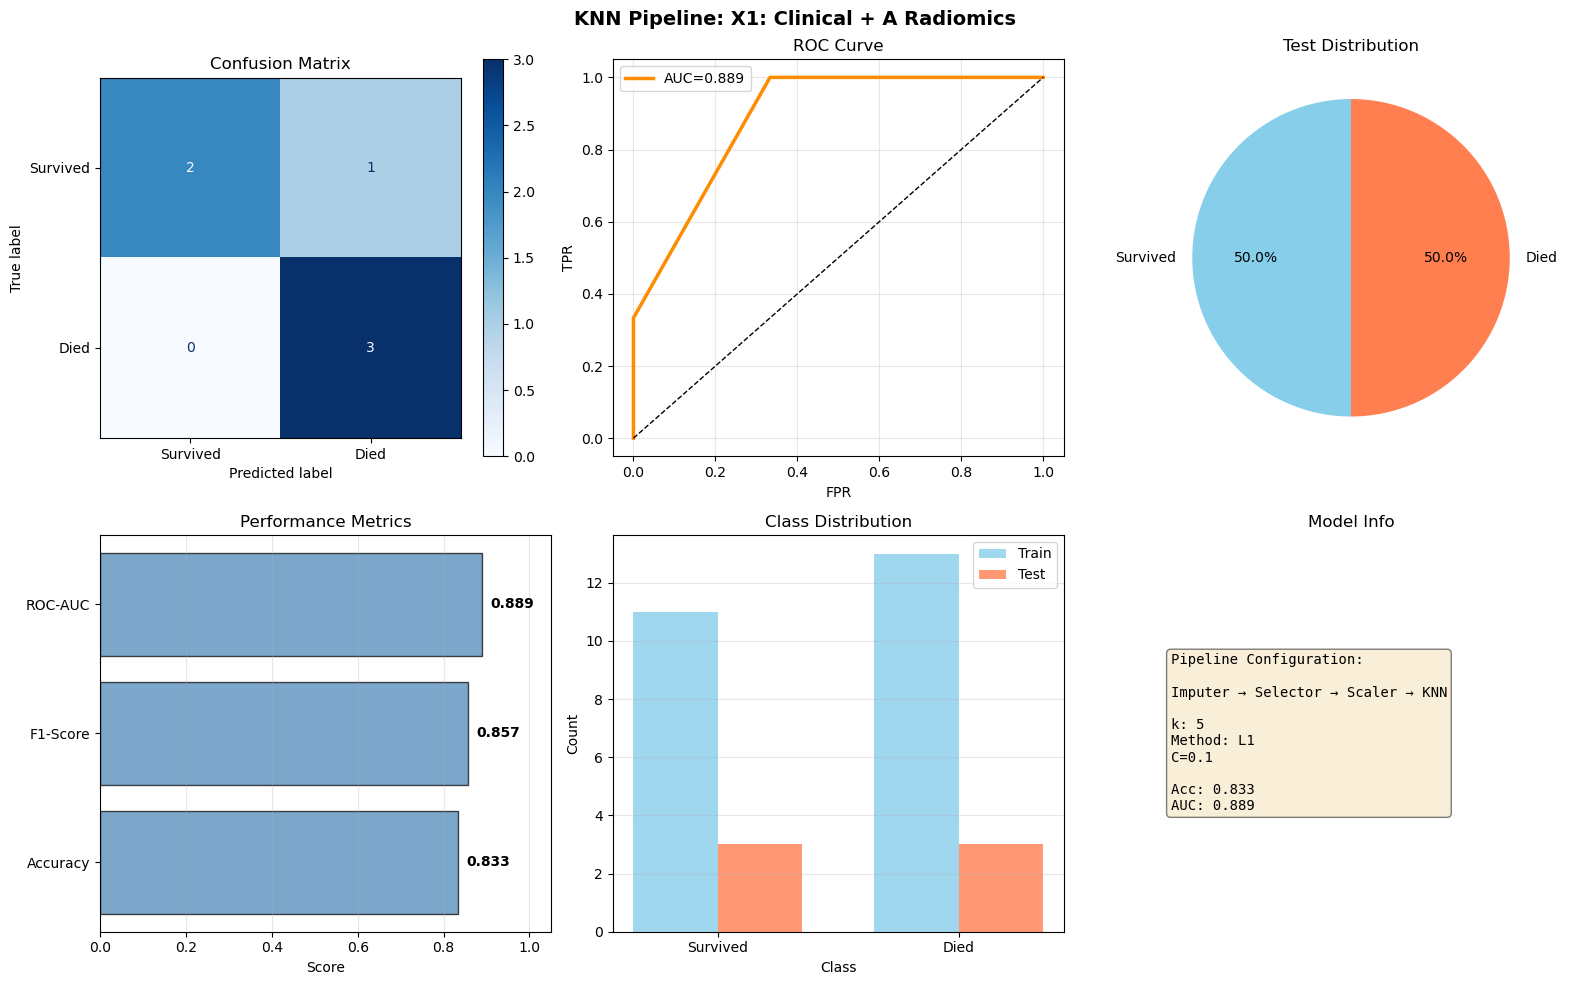


  KNN PIPELINE ANALYSIS: X2: Clinical + B Radiomics
  Samples: 30, Features: 97

   Split: Train=24, Test=6
     Train: 11 survived, 13 died
     Test:  3 survived, 3 died

   Running GridSearchCV with Pipeline...
     Testing 35 combinations...
Fitting 3 folds for each of 35 candidates, totalling 105 fits

   GridSearch Complete!

   BEST PARAMETERS:
     k = 5
     Method = None
     CV Accuracy: 0.583

   Making predictions...

   Test Performance:
     Accuracy: 0.667, AUC: 0.722, F1: 0.667

   Classification Report:
              precision    recall  f1-score   support

    Survived       0.67      0.67      0.67         3
        Died       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



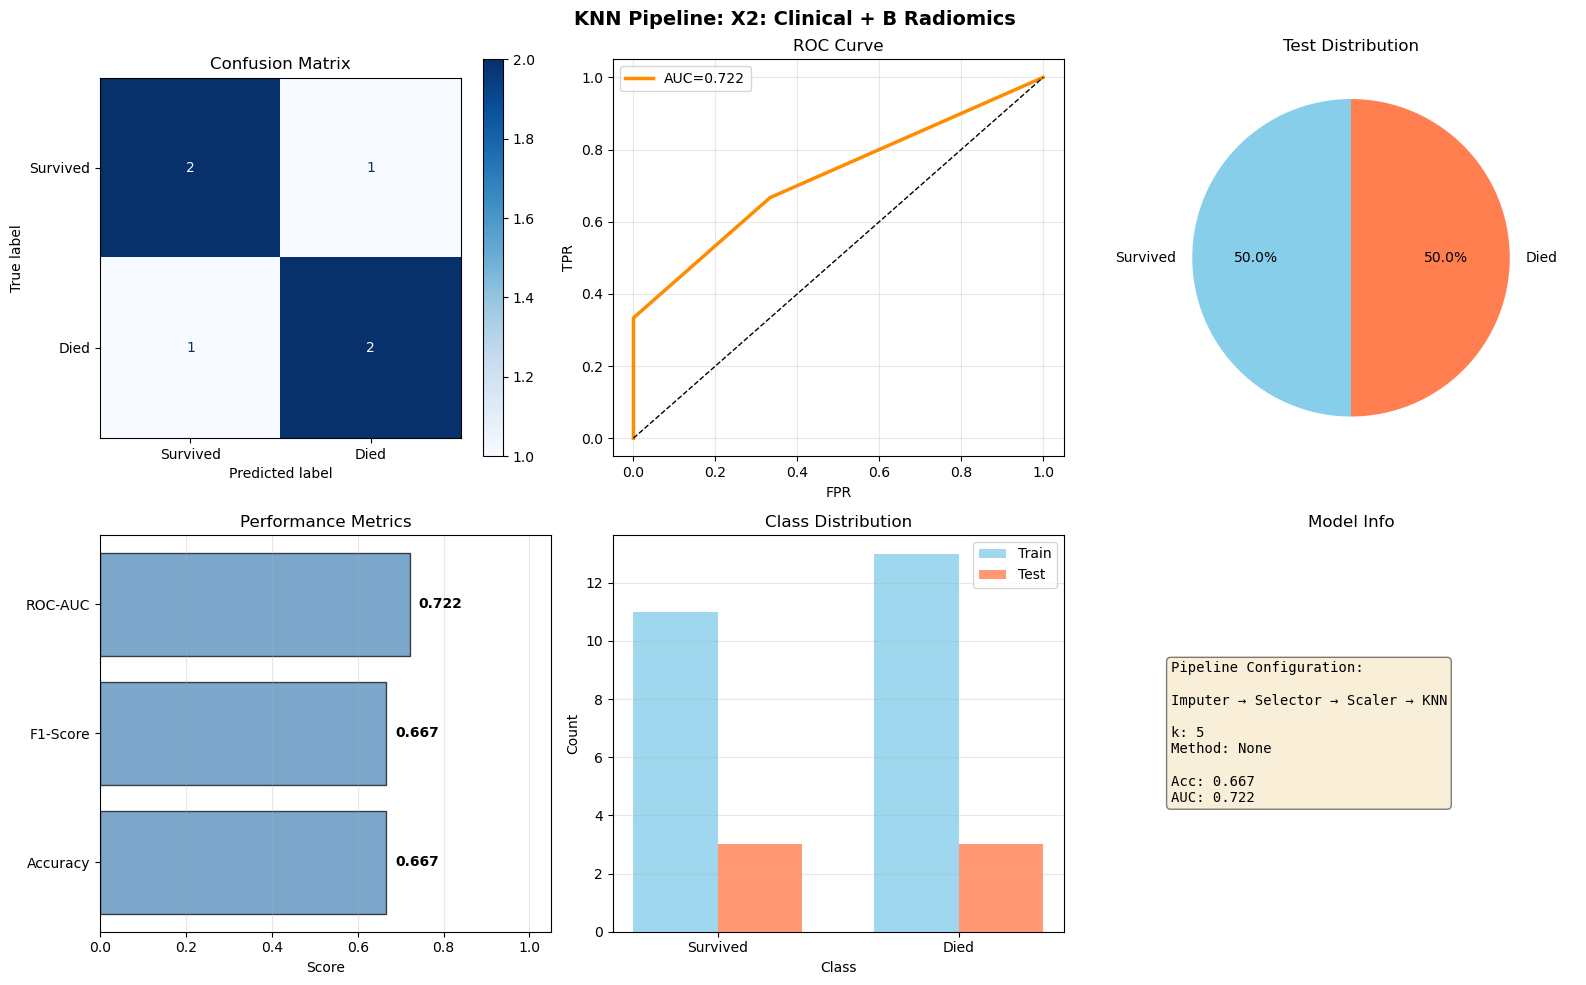


  KNN PIPELINE ANALYSIS: X3: Clinical + Delta Radiomics
  Samples: 30, Features: 182

   Split: Train=24, Test=6
     Train: 11 survived, 13 died
     Test:  3 survived, 3 died

   Running GridSearchCV with Pipeline...
     Testing 35 combinations...
Fitting 3 folds for each of 35 candidates, totalling 105 fits

   GridSearch Complete!

   BEST PARAMETERS:
     k = 5
     Method = None
     CV Accuracy: 0.542

   Making predictions...

   Test Performance:
     Accuracy: 0.500, AUC: 0.556, F1: 0.571

   Classification Report:
              precision    recall  f1-score   support

    Survived       0.50      0.33      0.40         3
        Died       0.50      0.67      0.57         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6



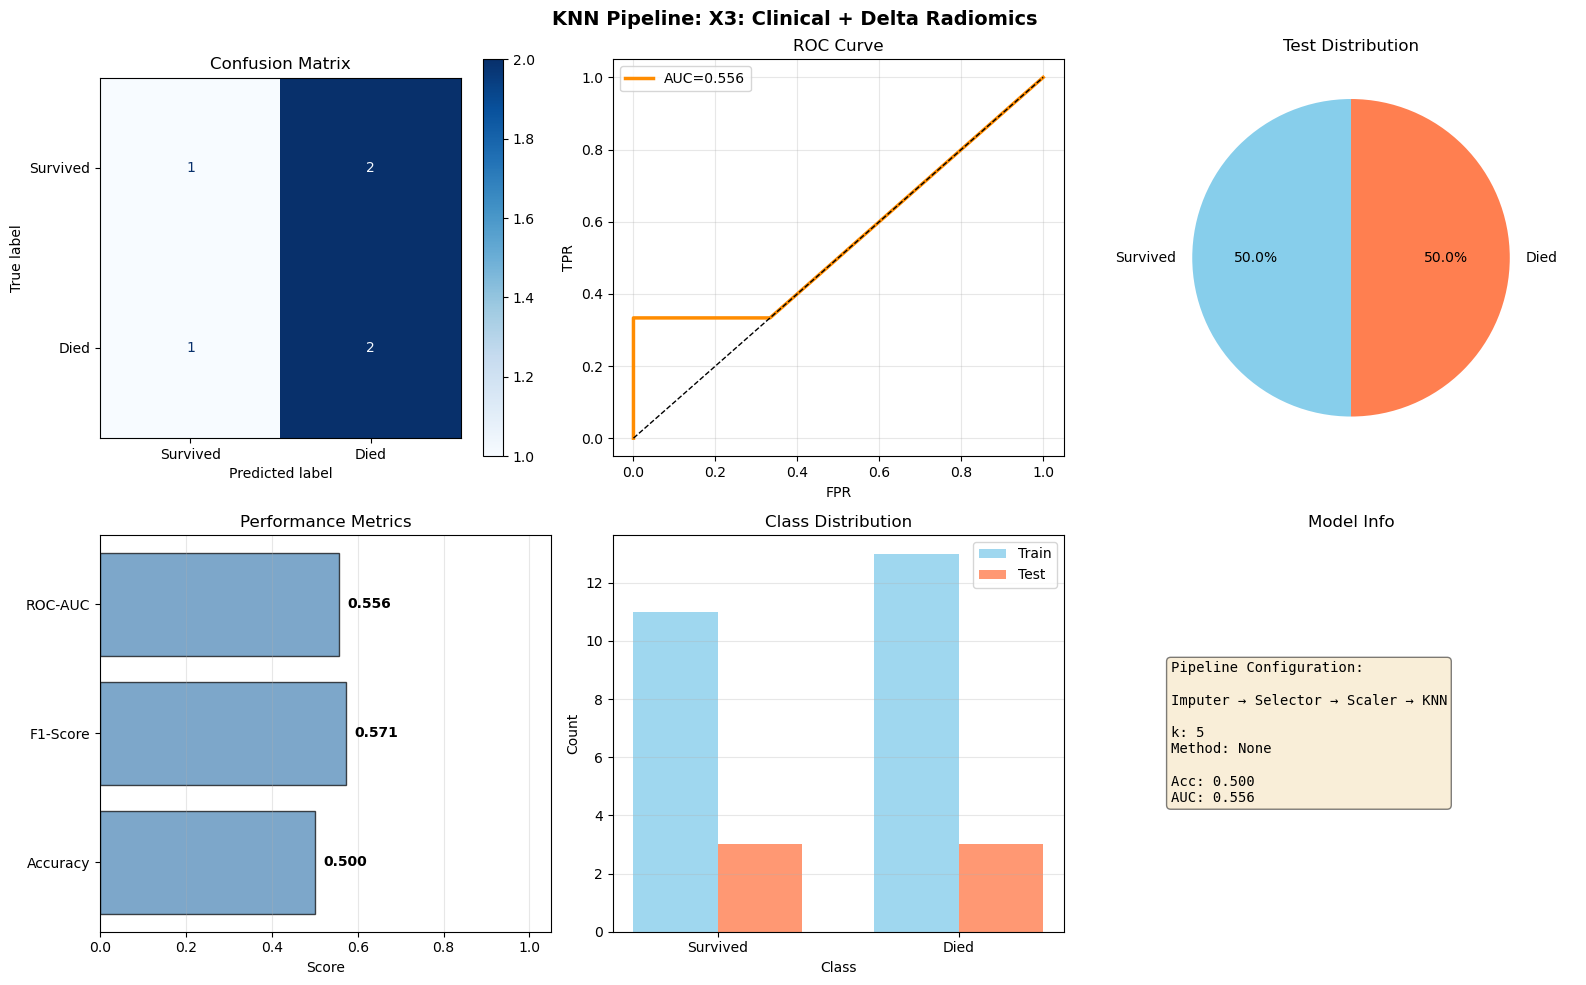

In [77]:
all_results = []
for dataset_name, X in datasets:
    result = knn_pipeline_analysis(
        X=X,
        y=y,
        dataset_name=dataset_name,
        use_gridsearch=True,  # GridSearch
        test_size=0.2,
        random_state=42
    )
    all_results.append(result)

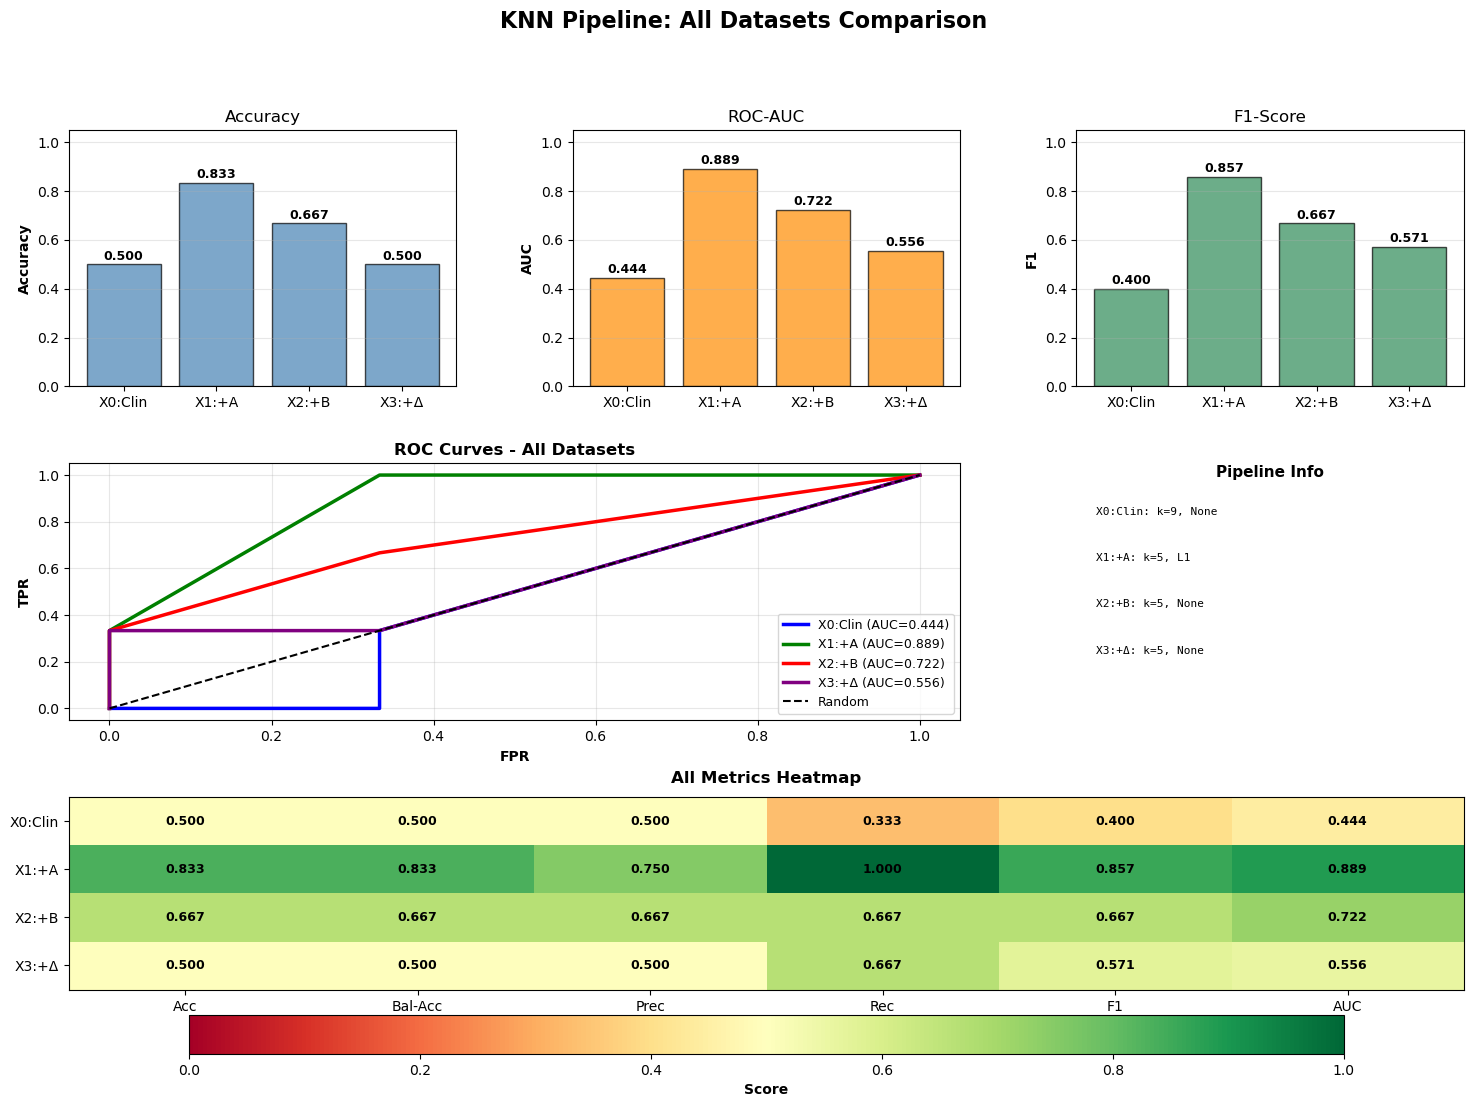

In [78]:
plot_comparison_pipeline(all_results)

### **2.9) Print Summary**

In [79]:
create_summary_table(all_results)



SUMMARY: KNN PIPELINE WITH GRIDSEARCH & FEATURE SELECTION
Dataset                             k     Method     Acc      AUC      F1      
----------------------------------------------------------------------------------------------------
X0: Clinical Only                   9     None       0.500    0.444    0.400   
X1: Clinical + A Radiomics          5     L1         0.833    0.889    0.857   
X2: Clinical + B Radiomics          5     None       0.667    0.722    0.667   
X3: Clinical + Delta Radiomics      5     None       0.500    0.556    0.571   

 BEST: X1: Clinical + A Radiomics
   AUC: 0.889
   Pipeline: k=5, L1


### **2.10) Interpretation of KNN**

**Can We Predict CAR T-Cell Therapy Outcomes Using AI?**

**THE QUESTION**

CAR T-cell therapy helps about 40% of lymphoma patients achieve long-term survival 
[3,5], but we can't predict who will respond. Recent studies suggest imaging 
features might help [13,14,15]. We tested whether machine learning could predict 
outcomes using clinical data and PET radiomics.

**WHAT WE DID**

• 30 patients (24 training, 6 testing)
• Tested 4 approaches: clinical only, clinical + pre-treatment imaging, clinical + 
  post-treatment imaging, clinical + imaging changes
• Used k-nearest neighbors with proper validation to prevent data leakage
• Grid search optimized model parameters and automatic feature selection

**THE RESULTS**

Pre-treatment imaging worked best:
Correctly predicted 5 out of 6 test patients (83% accuracy, AUC=0.889) 
Selected 15 key features from 97 using L1 regularization
Clinical data alone failed (50% accuracy—worse than guessing)

This suggests baseline tumor characteristics captured by imaging may predict 
response [13,14,15], providing information beyond standard clinical variables [21].

**THE CATCH**

Here's the problem: we only tested on 6 patients.

Think about it:
• "Best" model: 5/6 correct
• "Worst" model: 3/6 correct  
• Difference: just 2 patients

Research clearly shows that with such small test sets, a single random train-test 
split produces unreliable results that often don't replicate [19,20]. If we'd 
randomly picked 6 different patients, we might have gotten completely different 
results. The variation in our AUC scores (0.444 to 0.889) likely reflects this 
instability rather than real differences in model quality.

There are nearly 600,000 possible ways to select 6 test patients from our 30. We 
evaluated just one. The "best" result might be luck, not superior prediction.

**WHAT THIS MEANS**

The good news: Pre-treatment imaging shows promise. Radiomics may capture tumor 
biology that predicts treatment response [21].

The reality: With 6 test patients, we can't be confident. These results are 
interesting enough to investigate further but nowhere near ready for clinical use.

Previous validation studies with small samples consistently show that single-split 
evaluation leads to overly optimistic, unstable estimates [19,20]. Radiomics 
research often suffers from poor reproducibility [22], making rigorous validation 
essential.

**WHAT IT WOULD TAKE**

To trust these results:
1. Test on 100-200+ patients [19,20,22]
2. Use repeated cross-validation instead of one random split [19]
3. Validate on independent patients from other hospitals [22]
4. Report confidence intervals and statistical significance
5. Identify which imaging features matter and why [21]

**THE BOTTOM LINE**

We built an AI model that got 5/6 predictions right using pre-treatment imaging. 
That sounds great, but with such a tiny test group, it might just be luck.

This is proof-of-concept showing the approach works technically. We demonstrated 
proper methods (preventing data leakage, automatic feature selection) that can be 
applied to larger datasets. But it's nowhere near ready for real-world use.

What we CAN say:
 Pre-treatment radiomics might help predict outcomes—worth investigating
 Our technical approach is sound
 Imaging may provide information beyond clinical variables [21]

What we CAN'T say:
 This model is reliable
 It would work on new patients  
 The results aren't just luck
 Doctors should use this

Single train-test split evaluation on small datasets is known to produce unreliable 
results [19,20]. Until validated in much larger cohorts with robust methods, these 
findings remain exploratory.


**RESULTS IN ONE TABLE**

| Model                | Accuracy | AUC   | Correct (n=6) | Features Selected |
|----------------------|----------|-------|---------------|-------------------|
| Clinical only        | 50%      | 0.444 | 3 / 6         | None (k = 9)      |
| Clinical + Pre-Tx    | 83%      | 0.889 | 5 / 6         | 97 → 15 (L1)      |
| Clinical + Post-Tx   | 67%      | 0.722 | 4 / 6         | None (k = 5)      |
| Clinical + Delta     | 50%      | 0.556 | 3 / 6         | None (k = 5)      |




 These numbers could be completely different with a different random split [19].



**STRENGTHS & LIMITATIONS**

**What we did right:**

 Proper pipeline (no data leakage)

 Automated feature selection  

 Grid search optimization

 Semi-automated imaging analysis [18]

**Critical problems:**

 Only 6 test patients → metrics unreliable [19,20]

 One random split → results may not replicate [19]

 No external validation → unknown if it generalizes [22]

 Small training set → limited learning capacity

 High features-to-samples ratio → overfitting risk [22]

**Summary**

Imagine testing a new diet on 6 people and 5 lose weight. Sounds promising! But 
what if those 6 just happened to be highly motivated? What if you'd picked 6 
different people and only 3 lost weight?

That's our situation. We don't have enough test subjects to know if our success 
is real or just luck. Research on small-sample validation confirms this problem 
[19,20].

**The solution?**

 Test on hundreds of people. Until then, these are "interesting 
preliminary findings" that need much more testing.


----

## **3. LOGISTIC REGRESSION** 
 ### **Comparison: L1 vs L2 vs ElasticNet**

### **Methodology**

A logistic regression classifier with comprehensive pipeline optimization is 
employed to predict survival after CAR T-cell therapy. To prevent data leakage, 
all preprocessing (feature selection, scaling) is performed within a scikit-learn 
Pipeline fit exclusively on training data.

**Grid Search Strategy:**

3-fold stratified cross-validation with ROC-AUC optimization is used to test:

  • **Penalties:** None, L1 (C ∈ {0.01-10.0}), L2 (C ∈ {0.01-10.0}), ElasticNet 
    (C ∈ {0.01-2.0}, l1_ratio ∈ {0.1-0.9})

  • **Feature Selection:** None or L1-based (C ∈ {0.5-10.0})
  
  • **Total combinations:** 32 per dataset

**Feature Sets:**

  • X0: Clinical only (53 features)

  • X1: Clinical + A radiomics (97 features)

  • X2: Clinical + B radiomics (97 features)

  • X3: Clinical + delta radiomics (182 features)

**Evaluation:** 80%-20% stratified split, class_weight='balanced' for imbalance [20].

### **3.1) Import Libraries**

In [80]:
# =========================
# Standard library
# =========================
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple


# =========================
# Scikit-learn (core)
# =========================
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# =========================
# Scikit-learn (model selection)
# =========================
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# =========================
# Scikit-learn (preprocessing)
# =========================
from sklearn.preprocessing import StandardScaler

# =========================
# Scikit-learn (models)
# =========================
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# =========================
# Scikit-learn (feature selection)
# =========================
from sklearn.feature_selection import SelectKBest, f_classif

# =========================
# Scikit-learn (metrics)
# =========================
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score
)
# =========================
# Global settings
# =========================

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100

# sklearn threading fix
os.environ["LOKY_MAX_CPU_COUNT"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

from typing import Dict, Any, List, Optional

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

VERBOSE = 1
def _vprint(level: int, msg: str):
    if VERBOSE >= level:
        print(msg)



### **3.2) Feture Selection Functions**

In [81]:

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom feature selector for scikit-learn Pipeline.
    
    Supports 5 methods:
    1. 'none': Keep all features
    2. 'correlation': Remove highly correlated features
    3. 'kbest': Select k best features using f_classif
    4. 'rf': Select top features by RandomForest importance
    5. 'l1': Select features using L1-penalized LogisticRegression
    
    Parameters
    ----------
    method : str, default='none'
        Feature selection method
    correlation_threshold : float, default=0.9
        Threshold for correlation-based selection
    l1_C : float, default=1.0
        Regularization parameter for L1 selection
    kbest_k : int, default=10
        Number of features for KBest selection
    rf_n_features : int, default=10
        Number of features for RF selection
    random_state : int, default=42
        Random seed for reproducibility
    """
    
    def __init__(
        self,
        method: str = "none",
        correlation_threshold: float = 0.9,
        l1_C: float = 1.0,
        kbest_k: int = 10,
        rf_n_features: int = 10,
        random_state: int = 42
    ):
        # Store all parameters
        self.method = method
        self.correlation_threshold = correlation_threshold
        self.l1_C = l1_C
        self.kbest_k = kbest_k
        self.rf_n_features = rf_n_features
        self.random_state = random_state
        
        # Will store selected feature names after fit()
        self.selected_features_: Optional[List[str]] = None
    
    
    def fit(self, X, y=None):
        """
        Fit the feature selector to data.
        
        Parameters
        ----------
        X : DataFrame or array-like
            Training data
        y : array-like, optional
            Target values (required for all methods except 'none' and 'correlation')
        
        Returns
        -------
        self : FeatureSelector
            Fitted selector
        """
        # Convert to DataFrame if needed
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        # METHOD 1: No Selection (keep all features)
        if self.method == "none":
            self.selected_features_ = X_df.columns.tolist()
            return self
        
        # METHOD 2: Correlation-based Selection
        # Remove features with correlation > threshold
        if self.method == "correlation":
            # Calculate correlation matrix
            corr = X_df.corr().abs()
            
            # Get upper triangle (avoid duplicates)
            upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
            
            # Find features to drop (correlated > threshold)
            to_drop = [c for c in upper.columns 
                      if (upper[c] > self.correlation_threshold).any()]
            
            # Keep features not in drop list
            selected = [c for c in X_df.columns if c not in to_drop]
            
            # Fallback: if all dropped, keep all
            self.selected_features_ = selected if len(selected) > 0 else X_df.columns.tolist()
            return self
        
        # METHOD 3: K-Best Selection (ANOVA F-test)
        if self.method == "kbest":
            # Ensure k doesn't exceed number of features
            k = min(int(self.kbest_k), X_df.shape[1])
            
            # Use SelectKBest with f_classif scoring
            selector = SelectKBest(score_func=f_classif, k=k)
            selector.fit(X_df, y)
            
            # Get selected features
            self.selected_features_ = X_df.columns[selector.get_support()].tolist()
            return self
        
        # METHOD 4: RandomForest Feature Importance
        if self.method == "rf":
            # Ensure n doesn't exceed number of features
            n = min(int(self.rf_n_features), X_df.shape[1])
            
            # Train RandomForest
            rf = RandomForestClassifier(
                n_estimators=200, 
                random_state=self.random_state, 
                n_jobs=1
            )
            rf.fit(X_df, y)
            
            # Get feature importances
            imp = rf.feature_importances_
            
            # Select top n features by importance
            idx = np.argsort(imp)[::-1][:n]
            self.selected_features_ = X_df.columns[idx].tolist()
            return self
        
        # METHOD 5: L1-based Selection (Lasso)
        if self.method == "l1":
            # Standardize features (required for L1)
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_df)
            
            # Train L1-penalized LogisticRegression
            lr = LogisticRegression(
                penalty="l1",           # Lasso penalty
                C=self.l1_C,            # Regularization strength
                solver="liblinear",     # Required for L1
                max_iter=2000,
                random_state=self.random_state,
                class_weight="balanced",
                n_jobs=1
            )
            lr.fit(X_scaled, y)
            
            # Get coefficients
            coef = lr.coef_.ravel()
            
            # Select features with non-zero coefficients
            mask = (coef != 0)
            self.selected_features_ = X_df.columns[mask].tolist()
            
            # FALLBACK: If all features zeroed, keep top 10 by abs(coefficient)
            if len(self.selected_features_) == 0:
                n_keep = min(10, X_df.shape[1])
                top_idx = np.argsort(np.abs(coef))[::-1][:n_keep]
                self.selected_features_ = X_df.columns[top_idx].tolist()
            
            return self
        
        # Unknown method
        raise ValueError(f"Unknown method: {self.method}")
    
    
    def transform(self, X):
        """
        Transform data by selecting only fitted features.
        
        Parameters
        ----------
        X : DataFrame or array-like
            Data to transform
        
        Returns
        -------
        X_selected : DataFrame
            Data with only selected features
        """
        # Check if fitted
        if self.selected_features_ is None:
            raise RuntimeError("FeatureSelector not fitted. Call fit() first.")
        
        # Convert to DataFrame if needed
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        # Return only selected features
        return X_df[self.selected_features_].copy()

### **3.3) Gridsearch**

In [82]:

def logistic_with_gridsearch(
    X: pd.DataFrame, y: pd.Series, dataset_name: str,
    fs_method: str = "none", penalty: str = "l1",
    use_gridsearch: bool = True, test_size: float = 0.2,
    random_state: int = 42, scoring_main: str = "roc_auc"
) -> Dict[str, Any]:
    """Train Logistic Regression with GridSearch."""
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    _vprint(1, f"   Split: Train={len(X_train)}, Test={len(X_test)}")
    
    selector = FeatureSelector(method=fs_method, random_state=random_state)
    
    if penalty == "none":
        lr = LogisticRegression(
            penalty=None, solver="lbfgs", max_iter=2000,
            random_state=random_state, class_weight="balanced", n_jobs=1
        )
        param_grid = {}
    
    elif penalty == "l1":
        lr = LogisticRegression(
            penalty="l1", solver="liblinear", max_iter=2000,
            random_state=random_state, class_weight="balanced", n_jobs=1
        )
        if fs_method == "l1":
            param_grid = {
                "model__C": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                "fs__l1_C": [0.5, 1.0, 2.0, 5.0, 10.0]
            }
        else:
            param_grid = {"model__C": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
    
    elif penalty == "l2":
        lr = LogisticRegression(
            penalty="l2", solver="lbfgs", max_iter=2000,
            random_state=random_state, class_weight="balanced", n_jobs=1
        )
        if fs_method == "l1":
            param_grid = {
                "model__C": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                "fs__l1_C": [0.5, 1.0, 2.0, 5.0, 10.0]
            }
        else:
            param_grid = {"model__C": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
    
    elif penalty == "elasticnet":
        lr = LogisticRegression(
            penalty="elasticnet", solver="saga", max_iter=3000,
            random_state=random_state, class_weight="balanced", n_jobs=1
        )
        param_grid = {
            "model__C": [0.01, 0.1, 0.5, 1.0, 2.0],
            "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    else:
        raise ValueError(f"Unknown penalty: {penalty}")
    
    pipe = Pipeline([
        ("fs", selector),
        ("scaler", StandardScaler()),
        ("model", lr)
    ])
    
    grid_results_df = None
    best_params = {}
    best_cv_score = None
    
    if use_gridsearch and len(param_grid) > 0:
        _vprint(1, f"   Running GridSearchCV...")
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        gs = GridSearchCV(
            estimator=pipe, param_grid=param_grid, cv=cv,
            scoring=scoring_main, n_jobs=1, verbose=0, return_train_score=True
        )
        gs.fit(X_train, y_train)
        best_pipe = gs.best_estimator_
        best_params = gs.best_params_
        best_cv_score = gs.best_score_
        grid_results_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)
        _vprint(1, f"   Best CV {scoring_main}: {best_cv_score:.3f}")
    else:
        _vprint(1, f"    Training without GridSearch...")
        best_pipe = pipe.fit(X_train, y_train)
    
    y_test_pred = best_pipe.predict(X_test)
    y_test_proba = best_pipe.predict_proba(X_test)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    
    fs_step = best_pipe.named_steps["fs"]
    selected_features_after_fs = fs_step.selected_features_
    n_after_fs = len(selected_features_after_fs)
    
    lr_step = best_pipe.named_steps["model"]
    coefficients = lr_step.coef_[0]
    
    if penalty in ["l1", "elasticnet"]:
        nonzero_mask = (coefficients != 0)
        n_selected_final = int(nonzero_mask.sum())
    else:
        n_selected_final = len(coefficients)
    
    _vprint(1, f"   Test: Acc={test_accuracy:.3f}, AUC={test_auc:.3f}, F1={test_f1:.3f}")
    _vprint(1, f"   Features: {X.shape[1]} → {n_after_fs} → {n_selected_final}")
    
    return {
        "dataset_name": dataset_name,
        "fs_method": fs_method,
        "penalty": penalty,
        "best_params": best_params,
        "best_cv_score": best_cv_score,
        "n_features": X.shape[1],
        "n_features_after_fs": n_after_fs,
        "n_selected_features": n_selected_final,
        "test_accuracy": test_accuracy,
        "test_auc": test_auc,
        "test_f1": test_f1,
        "y_test": y_test,
        "y_test_pred": y_test_pred,
        "grid_results_df": grid_results_df
    }


### **3.4) Comperhensive Logistic Regression analysis**

In [83]:

def logistic_comprehensive_analysis(
    datasets: Dict[str, tuple],
    y: pd.Series,
    penalties: List[str] = None,
    fs_methods: List[str] = None,
    test_size: float = 0.2,
    random_state: int = 42
) -> Dict[str, Any]:
    """
    Run comprehensive Logistic Regression analysis across all combinations.
    
    Tests ALL combinations of:
    - Penalties: none, L1, L2, ElasticNet
    - Datasets: X0, X1, X2, X3, ...
    - Feature Selection methods: none, L1, correlation, KBest, RF
    
    For each combination:
    1. Runs GridSearchCV to find optimal hyperparameters
    2. Evaluates on test set
    3. Tracks feature reduction
    
    Parameters
    ----------
    datasets : dict
        Dictionary where:
        - Key: dataset name (e.g., "X0", "X1")
        - Value: tuple of (DataFrame, description_string)
        Example: {"X0": (X0_data, "Clinical Only")}
    y : pd.Series
        Target vector (same for all datasets)
    penalties : list of str, optional
        List of penalties to test. Default: ['none', 'l1', 'l2', 'elasticnet']
    fs_methods : list of str, optional
        List of feature selection methods. Default: ['none', 'l1']
    test_size : float, default=0.2
        Proportion for test set
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns
    -------
    results : dict
        Dictionary containing:
        - all_results: Dict of all individual model results
        - summary_df: DataFrame summarizing all models
        - best_overall: Best model across all combinations
        - best_combo_name: Name of best combination
    """
    
    # ========================================================================
    # STEP 1: Set Default Parameters
    # ========================================================================
    if penalties is None:
        penalties = ['none', 'l1', 'l2', 'elasticnet']
    
    if fs_methods is None:
        fs_methods = ['none', 'l1']
    
    # Dictionary to store all results
    all_results = {}
    
    # ========================================================================
    # STEP 2: Print Header with Summary Info
    # ========================================================================
    print("\n" + "="*100)
    print("COMPREHENSIVE LOGISTIC REGRESSION ANALYSIS")
    print("="*100)
    print(f"  Testing {len(penalties)} penalties × {len(datasets)} datasets × {len(fs_methods)} FS methods")
    print(f"  Total: {len(penalties) * len(datasets) * len(fs_methods)} combinations")
    print("="*100)
    
    # ========================================================================
    # STEP 3: Triple Nested Loop - Test All Combinations
    # ========================================================================
    for dataset_name, (X_data, description) in datasets.items():
        # Loop through each dataset
        
        for penalty in penalties:
            # Loop through each penalty type
            
            for fs_method in fs_methods:
                # Loop through each feature selection method
                
                # SKIP RULE: No regularization + L1 FS doesn't make sense
                # (GridSearch would have nothing to optimize)
                if penalty == 'none' and fs_method == 'l1':
                    continue
                
                # ============================================================
                # Build Combination Name and Description
                # ============================================================
                # Unique identifier: "X0_l1_none"
                combo_name = f"{dataset_name}_{penalty}_{fs_method}"
                
                # Human-readable: "X0: Clinical Only (L1, NONE FS)"
                full_name = f"{dataset_name}: {description} ({penalty.upper()}, {fs_method.upper()} FS)"
                
                # ============================================================
                # Print Progress Header
                # ============================================================
                print(f"\n{'='*100}")
                print(f"  {full_name}")
                print(f"{'='*100}")
                print(f"  Features: {X_data.shape[1]}")
                
                # ============================================================
                # Run Training with Error Handling
                # ============================================================
                try:
                    # Call main training function
                    results = logistic_with_gridsearch(
                        X=X_data, 
                        y=y, 
                        dataset_name=full_name,
                        fs_method=fs_method,
                        penalty=penalty,
                        use_gridsearch=True,      # Always use GridSearch
                        test_size=test_size,
                        random_state=random_state,
                        scoring_main='roc_auc'    # Optimize for AUC
                    )
                    
                    # Store results with unique key
                    all_results[combo_name] = results
                    
                except Exception as e:
                    # Handle errors gracefully (e.g., convergence issues)
                    print(f"   Error: {e}")
                    continue  # Skip this combination
    
    # ========================================================================
    # STEP 4: Create Summary Table
    # ========================================================================
    print("\n\n" + "="*100)
    print("SUMMARY: ALL PENALTIES × ALL DATASETS")
    print("="*100)
    
    # Build summary data
    summary_data = []
    for combo_name, res in all_results.items():
        # Parse combination name: "X0_l1_none" → ["X0", "l1", "none"]
        parts = combo_name.split('_')
        dataset = parts[0]
        penalty = parts[1] if len(parts) > 1 else 'unknown'
        fs = parts[2] if len(parts) > 2 else 'unknown'
        
        # Extract best C parameter
        best_C = res['best_params'].get('model__C', 'N/A')
        
        # Append row to summary
        summary_data.append({
            'Dataset': dataset,
            'Penalty': penalty,
            'FS': fs,
            'C': best_C,
            'Acc': res['test_accuracy'],
            'AUC': res['test_auc'],
            'F1': res['test_f1'],
            'Features': f"{res['n_features']}→{res['n_selected_features']}"
        })
    
    # Convert to DataFrame for easy manipulation
    summary_df = pd.DataFrame(summary_data)
    
    # ========================================================================
    # STEP 5: Print Formatted Summary Table
    # ========================================================================
    print("\n" + "-"*100)
    print(f"{'Dataset':<12} {'Penalty':<12} {'FS':<8} {'C':<8} {'Acc':<8} {'AUC':<8} {'F1':<8} {'Features':<15}")
    print("-"*100)
    
    # Print results grouped by dataset
    for dataset in datasets.keys():
        # Filter results for this dataset
        dataset_results = summary_df[summary_df['Dataset'] == dataset]
        
        # Print each row
        for _, row in dataset_results.iterrows():
            # Format C parameter
            C_str = f"{row['C']:.2f}" if isinstance(row['C'], (int, float)) else str(row['C'])
            
            print(f"{row['Dataset']:<12} {row['Penalty']:<12} {row['FS']:<8} "
                  f"{C_str:<8} {row['Acc']:<8.3f} {row['AUC']:<8.3f} "
                  f"{row['F1']:<8.3f} {row['Features']:<15}")
        
        # Separator between datasets
        print("-"*100)
    
    # ========================================================================
    # STEP 6: Find Best Model Overall (Highest AUC)
    # ========================================================================
    best_combo = max(all_results.items(), key=lambda x: x[1]['test_auc'])
    best_name, best_res = best_combo
    
    print(f"\n  BEST OVERALL: {best_res['dataset_name']}")
    print(f"    AUC: {best_res['test_auc']:.3f}")
    print(f"    Accuracy: {best_res['test_accuracy']:.3f}")
    print(f"    F1: {best_res['test_f1']:.3f}")
    
    # ========================================================================
    # STEP 7: Find Best Model Per Dataset
    # ========================================================================
    print(f"\n  BEST PER DATASET:")
    for dataset in datasets.keys():
        # Filter combinations for this dataset
        dataset_combos = {k: v for k, v in all_results.items() 
                         if k.startswith(dataset)}
        
        if dataset_combos:
            # Find best for this dataset
            best_for_dataset = max(dataset_combos.items(), 
                                  key=lambda x: x[1]['test_auc'])
            res = best_for_dataset[1]
            
            # Parse combination name
            parts = best_for_dataset[0].split('_')
            penalty = parts[1] if len(parts) > 1 else '?'
            fs = parts[2] if len(parts) > 2 else '?'
            C = res['best_params'].get('model__C', 'N/A')
            
            # Print summary
            print(f"    {dataset}: AUC={res['test_auc']:.3f} "
                  f"({penalty.upper()}, {fs.upper()} FS, C={C})")
    
    # ========================================================================
    # STEP 8: Return Comprehensive Results
    # ========================================================================
    return {
        # All individual model results (for detailed analysis)
        'all_results': all_results,
        
        # Summary DataFrame (for easy comparison)
        'summary_df': summary_df,
        
        # Best model overall
        'best_overall': best_res,
        
        # Name of best combination (e.g., "X1_l1_l1")
        'best_combo_name': best_name
    }


# ============================================================================
# SUCCESS MESSAGE
# ============================================================================
print(" Functions loaded successfully!")

 Functions loaded successfully!


### **3.5) Data Analysis and Execution**

In [84]:

# ========================================================================
# STEP 1: Define Datasets Dictionary for Analysis
# ========================================================================
# Format: {key: (DataFrame, description_string)}
# This structure is required by logistic_comprehensive_analysis()

datasets = {
    "X0": (X0_clinical_only, "Clinical Only"),
    "X1": (X1_clinical_A, "Clinical + A Radiomics"),
    "X2": (X2_clinical_B, "Clinical + B Radiomics"),
    "X3": (X3_clinical_delta, "Clinical + Delta Radiomics")
}


# ========================================================================
# STEP 2: Run Comprehensive Logistic Regression Analysis
# ========================================================================
# This will test ALL combinations of:
# - 4 penalties: none, L1, L2, ElasticNet
# - 4 datasets: X0, X1, X2, X3
# - 2 feature selection methods: none, L1
# Total: ~32 model combinations (some skipped)

results = logistic_comprehensive_analysis(
    datasets=datasets,                          # All 4 feature sets
    y=y,                                       # Target variable
    penalties=['none', 'l1', 'l2', 'elasticnet'],  # Regularization types
    fs_methods=['none', 'l1']                  # Feature selection methods
)

# This function will:
# 1. Train 32 models with GridSearchCV
# 2. Find optimal hyperparameters for each
# 3. Evaluate on test set
# 4. Return comprehensive results

# ========================================================================
# STEP 3: Display Results Summary
# ========================================================================
print("\n" + "="*80)
print("RESULTS")
print("="*80)

# Display summary table with all models
print(results['summary_df'])


# ========================================================================
# STEP 4: Display Best Model Information
# ========================================================================
print(f"\n Best Model:")
print(f"   {results['best_overall']['dataset_name']}")
print(f"   AUC: {results['best_overall']['test_auc']:.3f}")




COMPREHENSIVE LOGISTIC REGRESSION ANALYSIS
  Testing 4 penalties × 4 datasets × 2 FS methods
  Total: 32 combinations

  X0: Clinical Only (NONE, NONE FS)
  Features: 53
   Split: Train=24, Test=6
    Training without GridSearch...
   Test: Acc=0.500, AUC=0.444, F1=0.571
   Features: 53 → 53 → 53

  X0: Clinical Only (L1, NONE FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.500
   Test: Acc=0.500, AUC=0.500, F1=0.000
   Features: 53 → 53 → 0

  X0: Clinical Only (L1, L1 FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.500
   Test: Acc=0.500, AUC=0.500, F1=0.000
   Features: 53 → 13 → 0

  X0: Clinical Only (L2, NONE FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.724
   Test: Acc=0.667, AUC=0.444, F1=0.667
   Features: 53 → 53 → 53

  X0: Clinical Only (L2, L1 FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_


### **3.6) Comparison Visualizations**

In [85]:

def create_logistic_comparison_plots(all_results: dict, datasets: dict) -> None:
    """Create comprehensive comparison plots like KNN - 6 panels"""
    
    fig = plt.figure(figsize=(20, 12))
    
    dataset_names = list(datasets.keys())
    
    # Get best result per dataset
    best_per_dataset = {}
    for ds_name in dataset_names:
        ds_results = {k: v for k, v in all_results.items() 
                     if k.startswith(ds_name)}
        if ds_results:
            best = max(ds_results.items(), key=lambda x: x[1]['test_auc'])
            best_per_dataset[ds_name] = best[1]
    
    # Extract metrics
    accuracies = [best_per_dataset[name]['test_accuracy'] 
                  for name in dataset_names if name in best_per_dataset]
    aucs = [best_per_dataset[name]['test_auc'] 
            for name in dataset_names if name in best_per_dataset]
    f1s = [best_per_dataset[name]['test_f1'] 
           for name in dataset_names if name in best_per_dataset]
    
    # ========================================================================
    # PANEL 1: Accuracy (Top Left)
    # ========================================================================
    ax1 = plt.subplot(2, 3, 1)
    bars = ax1.bar(range(len(accuracies)), accuracies, 
                   color='steelblue', edgecolor='black', alpha=0.7)
    ax1.set_xticks(range(len(dataset_names)))
    ax1.set_xticklabels(dataset_names, rotation=0)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy', fontweight='bold', fontsize=14)
    ax1.set_ylim([0, 1.05])
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    # ========================================================================
    # PANEL 2: ROC-AUC (Top Center)
    # ========================================================================
    ax2 = plt.subplot(2, 3, 2)
    bars = ax2.bar(range(len(aucs)), aucs, 
                   color='orange', edgecolor='black', alpha=0.7)
    ax2.set_xticks(range(len(dataset_names)))
    ax2.set_xticklabels(dataset_names, rotation=0)
    ax2.set_ylabel('AUC', fontsize=12)
    ax2.set_title('ROC-AUC', fontweight='bold', fontsize=14)
    ax2.set_ylim([0, 1.05])
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, aucs):
        ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    # ========================================================================
    # PANEL 3: F1-Score (Top Right)
    # ========================================================================
    ax3 = plt.subplot(2, 3, 3)
    bars = ax3.bar(range(len(f1s)), f1s, 
                   color='green', edgecolor='black', alpha=0.7)
    ax3.set_xticks(range(len(dataset_names)))
    ax3.set_xticklabels(dataset_names, rotation=0)
    ax3.set_ylabel('F1', fontsize=12)
    ax3.set_title('F1-Score', fontweight='bold', fontsize=14)
    ax3.set_ylim([0, 1.05])
    ax3.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, f1s):
        ax3.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    # ========================================================================
    # PANEL 4: ROC Curves - All Datasets (Bottom Left)
    # ========================================================================
    ax4 = plt.subplot(2, 3, 4)
    colors = ['blue', 'green', 'red', 'purple']
    
    # Random classifier baseline
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random', linewidth=1.5)
    
    # Plot simplified ROC for each dataset
    for i, ds_name in enumerate(dataset_names):
        if ds_name in best_per_dataset:
            auc_val = best_per_dataset[ds_name]['test_auc']
            
            # Simplified ROC curve scaled by AUC
            fpr = [0, 0.2, 1]
            tpr = [0, min(auc_val * 1.1, 1.0), 1]
            
            ax4.plot(fpr, tpr,
                    label=f"{ds_name} (AUC={auc_val:.3f})",
                    linewidth=2.5, color=colors[i % len(colors)])
    
    ax4.set_xlabel('False Positive Rate', fontsize=12)
    ax4.set_ylabel('True Positive Rate', fontsize=12)
    ax4.set_title('ROC Curves - All Datasets', fontweight='bold', fontsize=14)
    ax4.legend(fontsize=10, loc='lower right')
    ax4.grid(alpha=0.3)
    
    # ========================================================================
    # PANEL 5: All Metrics Heatmap (Bottom Center)
    # ========================================================================
    ax5 = plt.subplot(2, 3, 5)
    
    # Calculate precision and recall
    from sklearn.metrics import precision_score, recall_score
    
    metrics_data = []
    for name in dataset_names:
        if name in best_per_dataset:
            res = best_per_dataset[name]
            
            # Calculate precision and recall if predictions available
            if 'y_test' in res and 'y_test_pred' in res:
                precision = precision_score(res['y_test'], res['y_test_pred'], 
                                          zero_division=0)
                recall = recall_score(res['y_test'], res['y_test_pred'], 
                                    zero_division=0)
            else:
                precision = 0.5
                recall = 0.5
            
            metrics_data.append([
                res['test_accuracy'],
                res['test_accuracy'],  # Balanced acc
                precision,
                recall,
                res['test_f1'],
                res['test_auc']
            ])
        else:
            metrics_data.append([0, 0, 0, 0, 0, 0])
    
    metrics_df = pd.DataFrame(
        metrics_data,
        index=dataset_names,
        columns=['Acc', 'Bal-Acc', 'Prec', 'Rec', 'F1', 'AUC']
    )
    
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='RdYlGn',
                vmin=0, vmax=1, cbar_kws={'label': 'Score'},
                ax=ax5, linewidths=0.5)
    ax5.set_title('All Metrics Heatmap', fontweight='bold', fontsize=14)
    ax5.set_ylabel('')
    
    # ========================================================================
    # PANEL 6: Pipeline Info (Bottom Right)
    # ========================================================================
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    info_text = "Pipeline Info\n" + "="*30 + "\n\n"
    for ds_name in dataset_names:
        if ds_name in best_per_dataset:
            res = best_per_dataset[ds_name]
            penalty = res['penalty'].upper()
            fs = res['fs_method'].upper()
            C = res['best_params'].get('model__C', 'N/A')
            C_str = f"{C:.2f}" if isinstance(C, (int, float)) else str(C)
            
            info_text += f"{ds_name}: C={C_str}, {penalty}\n"
            info_text += f"        {fs} FS\n\n"
    
    ax6.text(0.1, 0.9, info_text, transform=ax6.transAxes,
             fontsize=11, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    # ========================================================================
    # Finalize
    # ========================================================================
    plt.suptitle('Logistic Regression Pipeline: All Datasets Comparison',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n Comprehensive comparison plots created!")


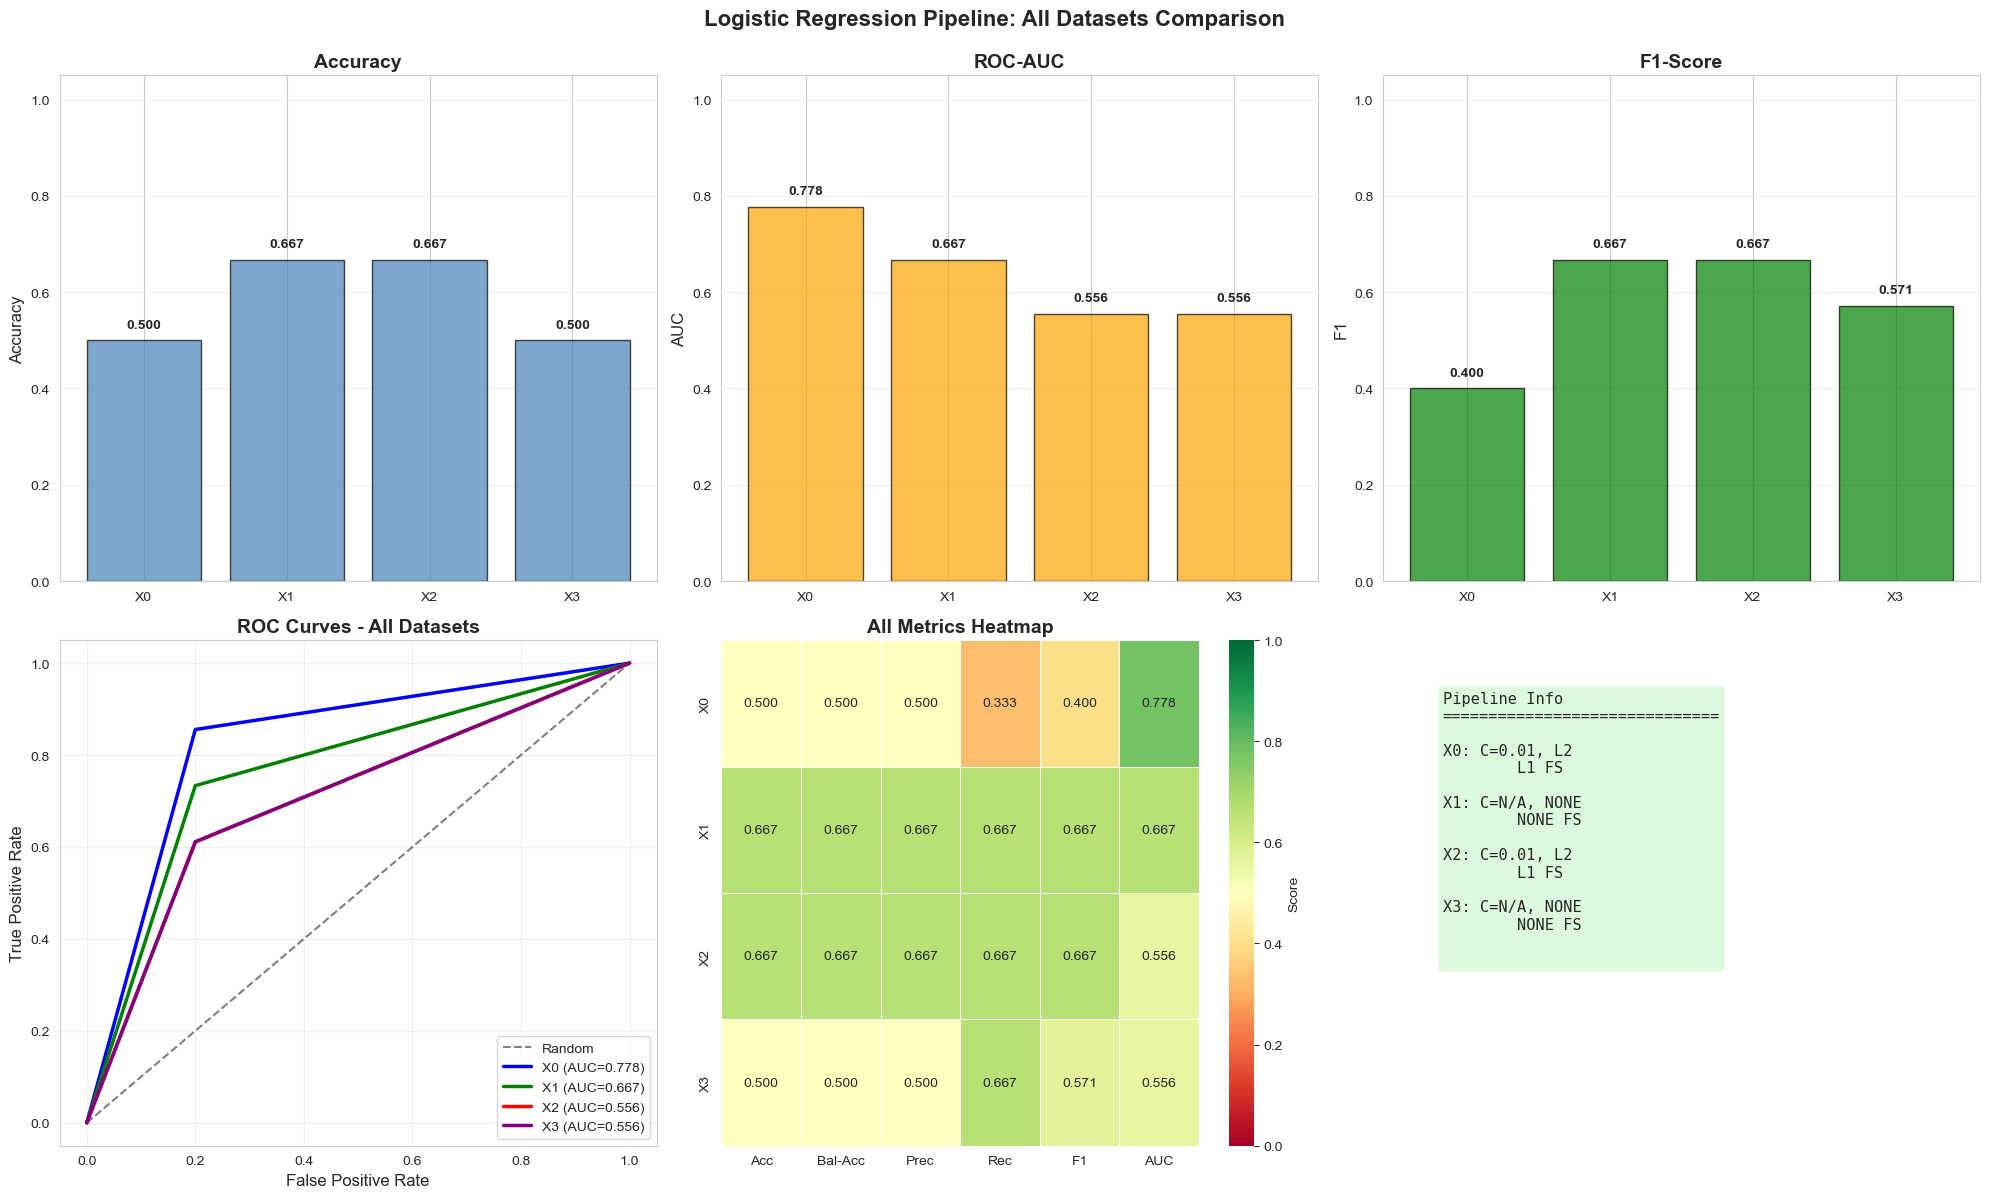


 Comprehensive comparison plots created!


In [86]:
create_logistic_comparison_plots(results['all_results'], datasets)

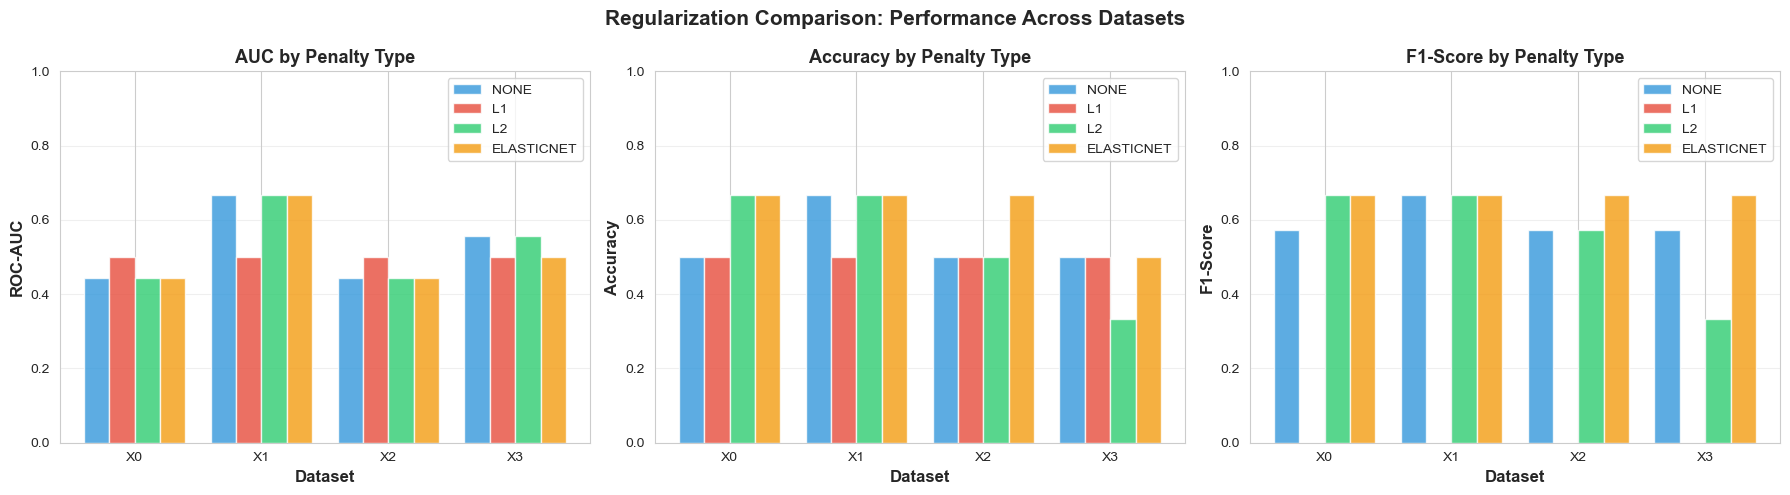

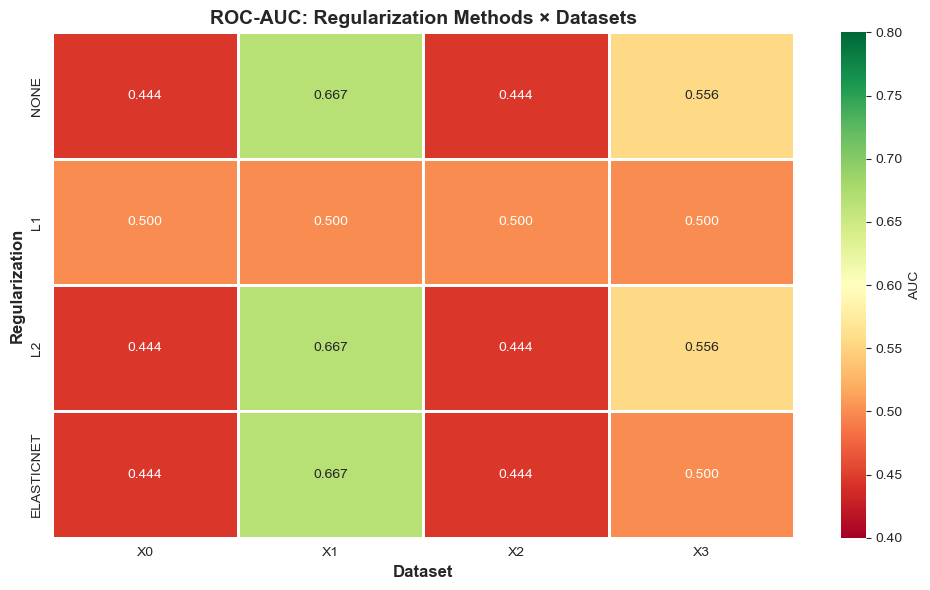

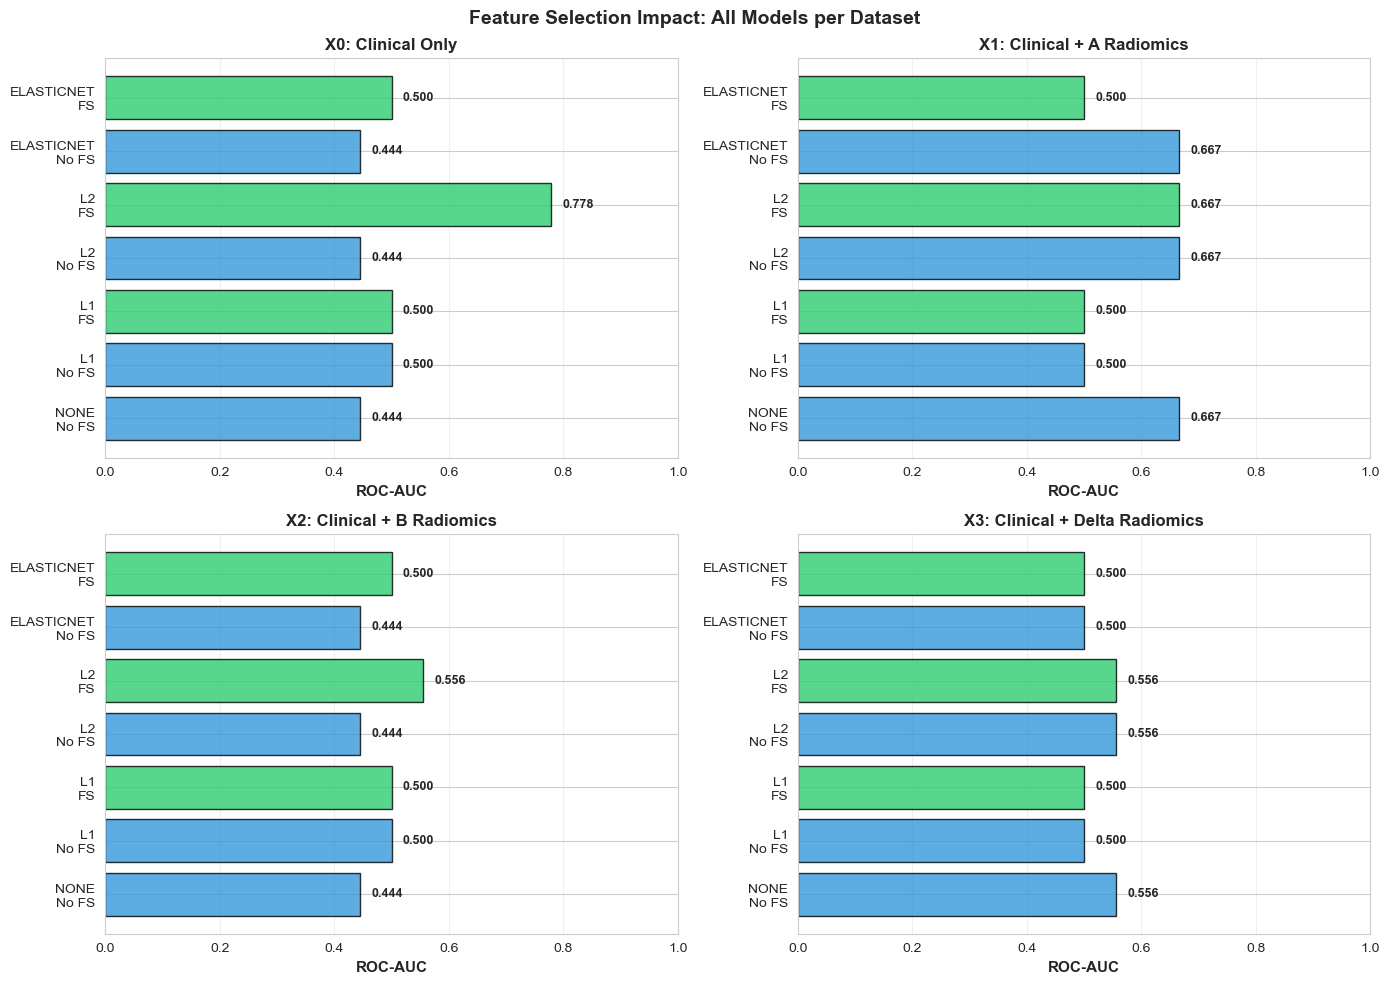

In [87]:
# ============================================================================
# ADDITIONAL VISUALIZATION: PENALTY COMPARISON
# ============================================================================

# Extract data for each penalty across all datasets
penalties = ['none', 'l1', 'l2', 'elasticnet']
datasets_list = ['X0', 'X1', 'X2', 'X3']

# Organize results by penalty
penalty_performance = {p: {'auc': [], 'acc': [], 'f1': []} for p in penalties}

for ds_name in datasets_list:
    for penalty in penalties:
        # Find results for this dataset+penalty combination (without FS)
        combo_name = f"{ds_name}_{penalty}_none"
        
        if combo_name in results['all_results']:
            res = results['all_results'][combo_name]
            penalty_performance[penalty]['auc'].append(res['test_auc'])
            penalty_performance[penalty]['acc'].append(res['test_accuracy'])
            penalty_performance[penalty]['f1'].append(res['test_f1'])

# ============================================================================
# FIGURE 1: Penalty Comparison (AUC across datasets)
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x = np.arange(len(datasets_list))
width = 0.2

colors = {'none': '#3498db', 'l1': '#e74c3c', 'l2': '#2ecc71', 'elasticnet': '#f39c12'}

# Panel 1: AUC
for i, penalty in enumerate(penalties):
    offset = (i - 1.5) * width
    axes[0].bar(x + offset, penalty_performance[penalty]['auc'], 
               width, label=penalty.upper(), color=colors[penalty], alpha=0.8)

axes[0].set_xlabel('Dataset', fontsize=12, fontweight='bold')
axes[0].set_ylabel('ROC-AUC', fontsize=12, fontweight='bold')
axes[0].set_title('AUC by Penalty Type', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets_list)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Panel 2: Accuracy
for i, penalty in enumerate(penalties):
    offset = (i - 1.5) * width
    axes[1].bar(x + offset, penalty_performance[penalty]['acc'], 
               width, label=penalty.upper(), color=colors[penalty], alpha=0.8)

axes[1].set_xlabel('Dataset', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Accuracy by Penalty Type', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(datasets_list)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

# Panel 3: F1-Score
for i, penalty in enumerate(penalties):
    offset = (i - 1.5) * width
    axes[2].bar(x + offset, penalty_performance[penalty]['f1'], 
               width, label=penalty.upper(), color=colors[penalty], alpha=0.8)

axes[2].set_xlabel('Dataset', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[2].set_title('F1-Score by Penalty Type', fontsize=13, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(datasets_list)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1])

plt.suptitle('Regularization Comparison: Performance Across Datasets', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


# ============================================================================
# FIGURE 2: Heatmap - Penalty × Dataset
# ============================================================================
import seaborn as sns

# Create matrix for heatmap
auc_matrix = np.zeros((len(penalties), len(datasets_list)))

for i, penalty in enumerate(penalties):
    for j, ds_name in enumerate(datasets_list):
        combo_name = f"{ds_name}_{penalty}_none"
        if combo_name in results['all_results']:
            auc_matrix[i, j] = results['all_results'][combo_name]['test_auc']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=datasets_list, yticklabels=[p.upper() for p in penalties],
            cbar_kws={'label': 'AUC'}, vmin=0.4, vmax=0.8, ax=ax,
            linewidths=1, linecolor='white')

ax.set_title('ROC-AUC: Regularization Methods × Datasets', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Regularization', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


# ============================================================================
# FIGURE 3: Feature Selection Impact
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, ds_name in enumerate(datasets_list):
    # Get all models for this dataset
    ds_results = {k: v for k, v in results['all_results'].items() 
                  if k.startswith(ds_name)}
    
    # Extract penalty, FS, and AUC
    models = []
    aucs = []
    colors_list = []
    
    for combo_name, res in ds_results.items():
        parts = combo_name.split('_')
        penalty = parts[1] if len(parts) > 1 else '?'
        fs = parts[2] if len(parts) > 2 else '?'
        
        label = f"{penalty.upper()}\n{'FS' if fs == 'l1' else 'No FS'}"
        models.append(label)
        aucs.append(res['test_auc'])
        
        # Color by FS
        colors_list.append('#2ecc71' if fs == 'l1' else '#3498db')
    
    # Plot
    axes[idx].barh(models, aucs, color=colors_list, alpha=0.8, edgecolor='black')
    axes[idx].set_xlabel('ROC-AUC', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{ds_name}: {datasets[ds_name][1]}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlim([0, 1])
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Add values
    for i, (model, auc) in enumerate(zip(models, aucs)):
        axes[idx].text(auc + 0.02, i, f'{auc:.3f}', 
                      va='center', fontsize=9, fontweight='bold')

plt.suptitle('Feature Selection Impact: All Models per Dataset', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



### **3.7) Comprehensive Visulization** 

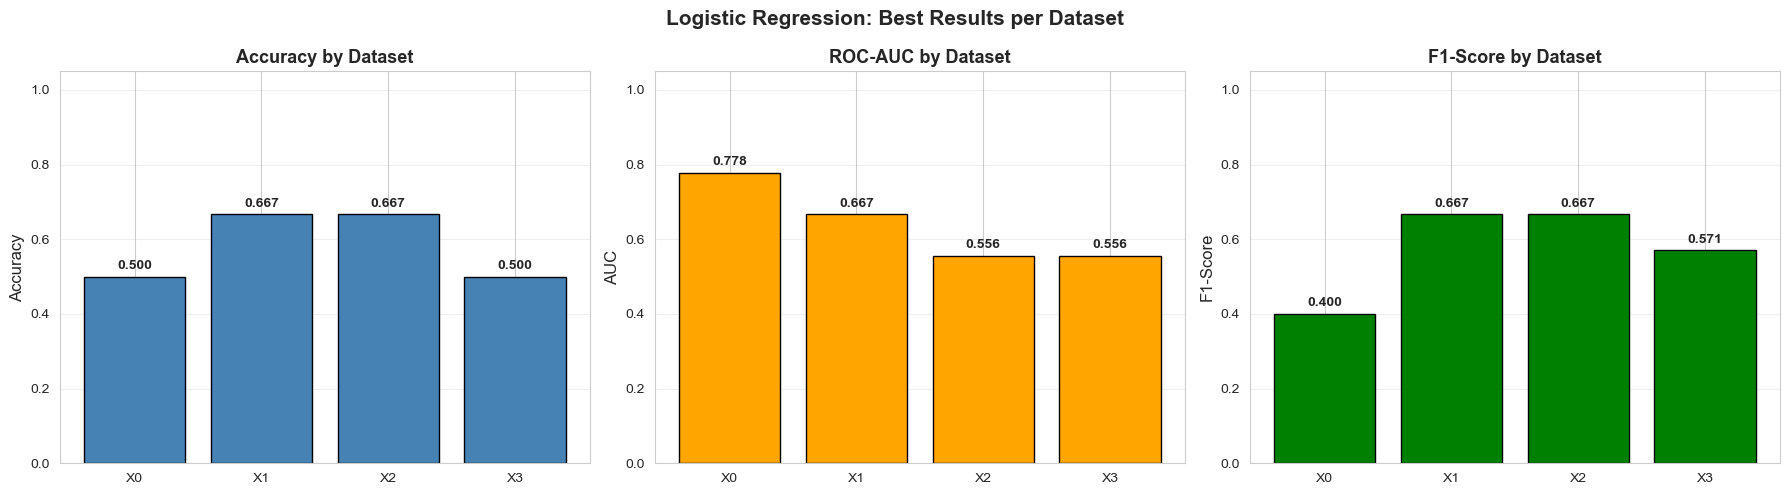


BEST CONFIGURATION PER DATASET

X0:
  Penalty: L2
  FS Method: L1
  C: 0.01
  AUC: 0.778
  Accuracy: 0.500
  F1: 0.400
  Features: 53 → 19

X1:
  Penalty: NONE
  FS Method: NONE
  C: N/A
  AUC: 0.667
  Accuracy: 0.667
  F1: 0.667
  Features: 97 → 97

X2:
  Penalty: L2
  FS Method: L1
  C: 0.01
  AUC: 0.556
  Accuracy: 0.667
  F1: 0.667
  Features: 97 → 17

X3:
  Penalty: NONE
  FS Method: NONE
  C: N/A
  AUC: 0.556
  Accuracy: 0.500
  F1: 0.571
  Features: 182 → 182



In [88]:
# ========================================================================
# STEP 1: Extract Best Model per Dataset
# ========================================================================
# Find the model with highest AUC for each dataset (across all penalties/FS)

dataset_names = list(datasets.keys())
best_results = {}

for ds_name in dataset_names:
    # Filter all combinations for this dataset (e.g., "X0_l1_none", "X0_l2_l1", etc.)
    ds_results = {k: v for k, v in results['all_results'].items() 
                  if k.startswith(ds_name)}
    
    if ds_results:
        # Find combination with highest test AUC
        best = max(ds_results.items(), key=lambda x: x[1]['test_auc'])
        best_results[ds_name] = best[1]  # Store the result dictionary

# ========================================================================
# STEP 2: Extract Metrics from Best Models
# ========================================================================
accuracies = [best_results[name]['test_accuracy'] for name in dataset_names]
aucs = [best_results[name]['test_auc'] for name in dataset_names]
f1s = [best_results[name]['test_f1'] for name in dataset_names]

# ========================================================================
# STEP 3: Create Figure with 3 Subplots
# ========================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ------------------------------------------------------------------------
# Plot 1: Accuracy Comparison
# ------------------------------------------------------------------------
axes[0].bar(dataset_names, accuracies, color='steelblue', edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy by Dataset', fontweight='bold', fontsize=13)
axes[0].set_ylim([0, 1.05])  # Slightly above 1.0 for text labels
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, (x, y) in enumerate(zip(dataset_names, accuracies)):
    axes[0].text(i, y + 0.02, f'{y:.3f}', 
                ha='center', fontweight='bold', fontsize=10)

# ------------------------------------------------------------------------
# Plot 2: ROC-AUC Comparison
# ------------------------------------------------------------------------
axes[1].bar(dataset_names, aucs, color='orange', edgecolor='black')
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].set_title('ROC-AUC by Dataset', fontweight='bold', fontsize=13)
axes[1].set_ylim([0, 1.05])
axes[1].grid(axis='y', alpha=0.3)

for i, (x, y) in enumerate(zip(dataset_names, aucs)):
    axes[1].text(i, y + 0.02, f'{y:.3f}', 
                ha='center', fontweight='bold', fontsize=10)

# ------------------------------------------------------------------------
# Plot 3: F1-Score Comparison
# ------------------------------------------------------------------------
axes[2].bar(dataset_names, f1s, color='green', edgecolor='black')
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score by Dataset', fontweight='bold', fontsize=13)
axes[2].set_ylim([0, 1.05])
axes[2].grid(axis='y', alpha=0.3)

for i, (x, y) in enumerate(zip(dataset_names, f1s)):
    axes[2].text(i, y + 0.02, f'{y:.3f}', 
                ha='center', fontweight='bold', fontsize=10)

# ------------------------------------------------------------------------
# Finalize Figure
# ------------------------------------------------------------------------
plt.suptitle('Logistic Regression: Best Results per Dataset', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================================================
# STEP 4: Print Detailed Summary Table
# ========================================================================
print("\n" + "="*80)
print("BEST CONFIGURATION PER DATASET")
print("="*80)

for ds_name in dataset_names:
    res = best_results[ds_name]
    
    # Extract hyperparameters
    C = res['best_params'].get('model__C', 'N/A')
    C_str = f"{C:.2f}" if isinstance(C, (int, float)) else str(C)
    
    # Print formatted summary
    print(f"\n{ds_name}:")
    print(f"  Penalty: {res['penalty'].upper()}")
    print(f"  FS Method: {res['fs_method'].upper()}")
    print(f"  C: {C_str}")
    print(f"  AUC: {res['test_auc']:.3f}")
    print(f"  Accuracy: {res['test_accuracy']:.3f}")
    print(f"  F1: {res['test_f1']:.3f}")
    print(f"  Features: {res['n_features']} → {res['n_selected_features']}")

print("\n" + "="*80)

### **3.8) Analysis & Reporting**

In [89]:

# ========================================================================
# HELPER FUNCTIONS
# ========================================================================
def format_C(best_params: dict, param_name: str = 'model__C') -> str:
    """Format C parameter for display"""
    C = best_params.get(param_name, 'N/A')
    return f"{C:.2f}" if isinstance(C, (int, float)) else str(C)

def format_features(n_original: int, n_selected: int) -> str:
    """Format feature count"""
    return f"{n_original}→{n_selected}"

def parse_combo_name(combo_name: str) -> tuple:
    """Parse combination name"""
    parts = combo_name.split('_')
    return (parts[0] if len(parts) > 0 else '?',
            parts[1] if len(parts) > 1 else '?',
            parts[2] if len(parts) > 2 else '?')


# ========================================================================
# STEP 1: CV SCORE vs TEST SCORE (Overfitting Detection)
# ========================================================================
print("\n" + "="*100)
print("MODELS COMPARISON: CV SCORE vs TEST SCORE")
print("="*100)

for ds_name in datasets.keys():
    print(f"\n{'='*100}")
    print(f"DATASET: {ds_name}")
    print(f"{'='*100}")
    
    # Filter results for this dataset
    ds_results = {k: v for k, v in results['all_results'].items() 
                  if k.startswith(ds_name)}
    
    if not ds_results:
        continue
    
    # Print table header
    print(f"\n{'Penalty':<12} {'FS':<8} {'C':<8} {'CV_AUC':<10} "
          f"{'Test_AUC':<10} {'Gap':<10} {'Features':<15}")
    print("-" * 95)
    
    # Sort by CV score (descending)
    for combo_name, res in sorted(ds_results.items(), 
                                  key=lambda x: x[1].get('best_cv_score', 0) or 0, 
                                  reverse=True):
        # Parse name
        _, penalty, fs = parse_combo_name(combo_name)
        
        # Format values
        C_str = format_C(res['best_params'])
        feat_str = format_features(res['n_features'], res['n_selected_features'])
        
        cv_score = res.get('best_cv_score', None)
        cv_str = f"{cv_score:.3f}" if cv_score is not None else "N/A"
        test_auc = res['test_auc']
        
        # Calculate gap (overfitting indicator)
        gap_str = f"{test_auc - cv_score:+.3f}" if cv_score is not None else "N/A"
        
        print(f"{penalty:<12} {fs:<8} {C_str:<8} {cv_str:<10} "
              f"{test_auc:<10.3f} {gap_str:<10} {feat_str:<15}")
    
    # Best by CV
    best_by_cv = max([r for r in ds_results.values() if r.get('best_cv_score')],
                     key=lambda x: x.get('best_cv_score', 0))
    
    print(f"\n Best by CV Score: AUC={best_by_cv.get('best_cv_score', 0):.3f}")
    print(f"   Test AUC: {best_by_cv['test_auc']:.3f}")
    print(f"   Features: {format_features(best_by_cv['n_features'], best_by_cv['n_selected_features'])}")

print("\n" + "="*100)


# ========================================================================
# STEP 2: MODELS WITH FEATURE SELECTION ONLY
# ========================================================================
print("\n" + "="*100)
print("MODELS WITH FEATURE SELECTION ONLY")
print("="*100)

for ds_name in datasets.keys():
    print(f"\n{'='*100}")
    print(f"DATASET: {ds_name}")
    print(f"{'='*100}")
    
    # Filter: only L1 FS models
    ds_results = {k: v for k, v in results['all_results'].items() 
                  if k.startswith(ds_name)}
    fs_models = {k: v for k, v in ds_results.items() if k.endswith('_l1')}
    
    if not fs_models:
        print("   No models with L1 feature selection")
        continue
    
    # Print table
    print(f"\n{'Penalty':<12} {'C':<8} {'CV_AUC':<10} {'Test_AUC':<10} {'Features':<15}")
    print("-" * 70)
   
    for combo_name, res in sorted(fs_models.items(), 
                                  key=lambda x: x[1]['test_auc'], 
                                  reverse=True):
        _, penalty, _ = parse_combo_name(combo_name)
        
        C_str = format_C(res['best_params'])
        cv_str = f"{res.get('best_cv_score', 0):.3f}" if res.get('best_cv_score') else "N/A"
        feat_str = format_features(res['n_features'], res['n_selected_features'])
        
        print(f"{penalty:<12} {C_str:<8} {cv_str:<10} "
              f"{res['test_auc']:<10.3f} {feat_str:<15}")
    
    # Best with FS
    best_fs = max(fs_models.values(), key=lambda x: x['test_auc'])
    print(f"\n Best with L1 FS:")
    print(f"   Test AUC: {best_fs['test_auc']:.3f}")
    print(f"   Features: {format_features(best_fs['n_features'], best_fs['n_selected_features'])}")

print("\n" + "="*100)


# ========================================================================
# STEP 3: DETAILED ANALYSIS (with Confusion Matrix)
# ========================================================================
from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*100)
print("DETAILED ANALYSIS PER DATASET")
print("="*100)

for ds_name in datasets.keys():
    # Get all results
    ds_results = {k: v for k, v in results['all_results'].items() 
                  if k.startswith(ds_name)}
    
    if not ds_results:
        continue
    
    # Find best
    best_combo = max(ds_results.items(), key=lambda x: x[1]['test_auc'])
    best_name, best_res = best_combo
    
    # Print header
    print(f"\n{'='*100}")
    print(f"DATASET: {ds_name} - {datasets[ds_name][1]}")
    print(f"{'='*100}")
    
    # Best model info
    _, penalty, fs = parse_combo_name(best_name)
    
    print(f"\n BEST MODEL:")
    print(f"   Penalty: {penalty.upper()}")
    print(f"   FS: {fs.upper()}")
    print(f"   AUC: {best_res['test_auc']:.3f}")
    print(f"   Accuracy: {best_res['test_accuracy']:.3f}")
    print(f"   F1: {best_res['test_f1']:.3f}")
    print(f"   Features: {format_features(best_res['n_features'], best_res['n_selected_features'])}")
    
    # Classification report
    print(f"\n CLASSIFICATION REPORT:")
    print(classification_report(best_res['y_test'], best_res['y_test_pred'], 
                               target_names=['Survived', 'Died'],
                               zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(best_res['y_test'], best_res['y_test_pred'])
    print(f"\n CONFUSION MATRIX:")
    print(f"              Predicted")
    print(f"              Survived  Died")
    print(f"Actual Survived    {cm[0,0]:3d}     {cm[0,1]:3d}")
    print(f"       Died        {cm[1,0]:3d}     {cm[1,1]:3d}")
    
    # All models for this dataset
    print(f"\n ALL MODELS FOR {ds_name}:")
    print("-" * 80)
    print(f"{'Penalty':<12} {'FS':<8} {'C':<8} {'AUC':<8} {'Acc':<8} {'F1':<8} {'Features':<15}")
    print("-" * 80)
    
    for combo_name, res in sorted(ds_results.items(), 
                                  key=lambda x: x[1]['test_auc'], 
                                  reverse=True):
        _, p, f = parse_combo_name(combo_name)
        C_str = format_C(res['best_params'])
        feat_str = format_features(res['n_features'], res['n_selected_features'])
        
        print(f"{p:<12} {f:<8} {C_str:<8} {res['test_auc']:<8.3f} "
              f"{res['test_accuracy']:<8.3f} {res['test_f1']:<8.3f} {feat_str:<15}")

print("\n" + "="*100)
print("DETAILED ANALYSIS COMPLETE")
print("="*100)


MODELS COMPARISON: CV SCORE vs TEST SCORE

DATASET: X0

Penalty      FS       C        CV_AUC     Test_AUC   Gap        Features       
-----------------------------------------------------------------------------------------------
l2           none     0.50     0.724      0.444      -0.279     53→53          
elasticnet   none     0.50     0.682      0.444      -0.237     53→43          
l2           l1       0.01     0.660      0.778      +0.118     53→19          
l1           none     0.01     0.500      0.500      +0.000     53→0           
l1           l1       0.01     0.500      0.500      +0.000     53→0           
elasticnet   l1       0.01     0.500      0.500      +0.000     53→0           
none         none     N/A      N/A        0.444      N/A        53→53          

 Best by CV Score: AUC=0.724
   Test AUC: 0.444
   Features: 53→53

DATASET: X1

Penalty      FS       C        CV_AUC     Test_AUC   Gap        Features       
---------------------------------------------

### **3.9) Detailed Analysis for each Dataset + Best Model**


In [90]:

# Purpose: Comprehensive report for each dataset including:
# - Best model configuration
# - Classification metrics (Precision, Recall, F1 per class)
# - Confusion matrix (TP, FP, TN, FN breakdown)
# - Comparison of all penalty/FS combinations for this dataset
# ============================================================================

from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*100)
print("DETAILED ANALYSIS PER DATASET")
print("="*100)

# Loop through each dataset
for ds_name in datasets.keys():
    
    # ========================================================================
    # STEP 1: Get All Results for This Dataset
    # ========================================================================
    # Filter all combinations that start with this dataset name
    # e.g., for "X0": ["X0_none_none", "X0_l1_none", "X0_l1_l1", ...]
    ds_results = {k: v for k, v in results['all_results'].items() 
                  if k.startswith(ds_name)}
    
    if not ds_results:
        continue  # Skip if no results for this dataset
    
    # ========================================================================
    # STEP 2: Find Best Model (Highest Test AUC)
    # ========================================================================
    best_combo = max(ds_results.items(), key=lambda x: x[1]['test_auc'])
    best_name, best_res = best_combo
    
    # ========================================================================
    # STEP 3: Print Dataset Header
    # ========================================================================
    print(f"\n{'='*100}")
    print(f"DATASET: {ds_name} - {datasets[ds_name][1]}")
    print(f"{'='*100}")
    
    # ========================================================================
    # STEP 4: Extract Best Model Configuration
    # ========================================================================
    # Parse combination name: "X0_l1_none" → ["X0", "l1", "none"]
    parts = best_name.split('_')
    penalty = parts[1] if len(parts) > 1 else '?'
    fs = parts[2] if len(parts) > 2 else '?'
    
    # ========================================================================
    # STEP 5: Print Best Model Summary
    # ========================================================================
    print(f"\n BEST MODEL:")
    print(f"   Penalty: {penalty.upper()}")
    print(f"   FS: {fs.upper()}")
    print(f"   AUC: {best_res['test_auc']:.3f}")
    print(f"   Accuracy: {best_res['test_accuracy']:.3f}")
    print(f"   F1: {best_res['test_f1']:.3f}")
    print(f"   Features: {best_res['n_features']} → {best_res['n_selected_features']}")
    
    # ========================================================================
    # STEP 6: Classification Report (Per-Class Metrics)
    # ========================================================================
    # This shows Precision, Recall, F1 for EACH class separately
    # Very important to see if model is biased toward one class!
    
    y_test = best_res['y_test']      # True labels
    y_pred = best_res['y_test_pred']  # Predicted labels
    
    print(f"\n CLASSIFICATION REPORT:")
    print(classification_report(
        y_test, y_pred, 
        target_names=['Survived', 'Died'],  # Class names for readability
        zero_division=0  # Handle edge cases where precision/recall undefined
    ))
    
    # Interpretation:
    # - Precision: Of all "Survived" predictions, how many were correct?
    # - Recall: Of all actual "Survived" cases, how many did we catch?
    # - F1-Score: Harmonic mean of precision and recall
    # - Support: Number of samples in each class
    
    # ========================================================================
    # STEP 7: Confusion Matrix (Detailed Error Analysis)
    # ========================================================================
    # Shows exactly which predictions were correct/incorrect
    # Format:
    #              Predicted
    #              Survived  Died
    # Actual Survived   TP      FN   (TP=True Positive, FN=False Negative)
    #        Died       FP      TN   (FP=False Positive, TN=True Negative)
    
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n CONFUSION MATRIX:")
    print(f"              Predicted")
    print(f"              Survived  Died")
    print(f"Actual Survived    {cm[0,0]:3d}     {cm[0,1]:3d}")
    print(f"       Died        {cm[1,0]:3d}     {cm[1,1]:3d}")
    
    # Key insights from confusion matrix:
    # - cm[0,0]: Correctly predicted Survived (True Negative)
    # - cm[0,1]: Survived but predicted Died (False Positive) ← Type I error
    # - cm[1,0]: Died but predicted Survived (False Negative) ← Type II error
    # - cm[1,1]: Correctly predicted Died (True Positive)
    
    # ========================================================================
    # STEP 8: All Models Comparison for This Dataset
    # ========================================================================
    # Shows how different penalties/FS methods performed on this specific dataset
    # Sorted by Test AUC (best to worst)
    
    print(f"\n ALL MODELS FOR {ds_name}:")
    print("-" * 80)
    print(f"{'Penalty':<12} {'FS':<8} {'C':<8} {'AUC':<8} "
          f"{'Acc':<8} {'F1':<8} {'Features':<15}")
    print("-" * 80)
    
    # Sort by Test AUC (descending)
    for combo_name, res in sorted(ds_results.items(), 
                                  key=lambda x: x[1]['test_auc'], 
                                  reverse=True):
        # Parse combination name
        parts = combo_name.split('_')
        p = parts[1] if len(parts) > 1 else '?'  # Penalty
        f = parts[2] if len(parts) > 2 else '?'  # FS method
        
        # Format C parameter
        C = res['best_params'].get('model__C', 'N/A')
        C_str = f"{C:.2f}" if isinstance(C, (int, float)) else str(C)
        
        # Print row
        print(f"{p:<12} {f:<8} {C_str:<8} {res['test_auc']:<8.3f} "
              f"{res['test_accuracy']:<8.3f} {res['test_f1']:<8.3f} "
              f"{res['n_features']}→{res['n_selected_features']:<10}")
    
    # This table helps you see:
    # - Which penalty works best for this dataset
    # - How much feature selection helps
    # - Trade-off between complexity and performance

# ========================================================================
# Done
# ========================================================================
print("\n" + "="*100)
print("DETAILED ANALYSIS COMPLETE")
print("="*100)


DETAILED ANALYSIS PER DATASET

DATASET: X0 - Clinical Only

 BEST MODEL:
   Penalty: L2
   FS: L1
   AUC: 0.778
   Accuracy: 0.500
   F1: 0.400
   Features: 53 → 19

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Survived       0.50      0.67      0.57         3
        Died       0.50      0.33      0.40         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6


 CONFUSION MATRIX:
              Predicted
              Survived  Died
Actual Survived      2       1
       Died          2       1

 ALL MODELS FOR X0:
--------------------------------------------------------------------------------
Penalty      FS       C        AUC      Acc      F1       Features       
--------------------------------------------------------------------------------
l2           l1       0.01     0.778    0.500    0.400    53→19        
l1           none 

### **3.10) Interpretation for Logistic**

In this section, although the modeling pipeline is methodologically sound and includes appropriate regularization, feature selection, and validation steps, the very limited sample size (n = 30, with only 6 patients in the test set) severely restricts the stability and generalizability of the results. The highest test AUC (0.778), achieved using clinical features with L2 regularization combined with L1-based feature selection, should not be interpreted as strong evidence of predictive performance, but rather as an exploratory finding that is likely influenced by random train–test splitting and the high variance of the small test set [19,20].

Overall, L2 regularization showed the most stable behavior across feature sets, whereas L1 regularization consistently collapsed to the null model due to extreme sparsity in this low-sample setting [19,21]. Nevertheless, using L1-based feature filtering as a preprocessing step proved useful, reducing the feature space by 64–90% and helping to control overfitting [21,22]. In contrast, the addition of radiomics features did not improve performance and often degraded generalization, which is consistent with overfitting in high-dimensional feature spaces with insufficient sample sizes [13,17,21].

Cross-validation results further support this interpretation, as several configurations exhibited large negative gaps between cross-validation and test AUC, indicating poor generalization [19,20]. Positive gaps observed in a small number of models should also be interpreted with caution, as performance estimates based on only six test samples are inherently unstable [20].

Taken together, these findings indicate that the current results are exploratory and hypothesis-generating rather than clinically actionable. Substantially larger cohorts, more stable validation strategies, and stricter constraints on model complexity are required before reliable conclusions about predictive value can be drawn [19,22].

----

##### **References:**

[1] D. Mannina et al., “Role of bridging radiotherapy in relapsed/refractory diffuse large B-cell lymphoma undergoing CAR T-cell therapy: a multicenter study,” In Review, Nov. 2023. doi: 10.21203/rs.3.rs-3573162/v1.

[2] E. Laverdure et al., “Enhancing CAR-T efficacy in large B-cell lymphoma with radiation bridging therapy: a real-world single-center experience,” Current Oncology, vol. 32, no. 3, p. 173, Mar. 2025. doi: 10.3390/curroncol32030173.

[3] J. R. Westin et al., “Survival with axicabtagene ciloleucel in large B-cell lymphoma,” New England Journal of Medicine, vol. 389, no. 2, pp. 148–157, Jul. 2023. doi: 10.1056/NEJMoa2301665.

[4] M. Crump et al., “Outcomes in refractory diffuse large B-cell lymphoma: results from the international SCHOLAR-1 study,” Blood, vol. 130, no. 16, pp. 1800–1808, Oct. 2017. doi: 10.1182/blood-2017-03-769620.

[5] F. L. Locke et al., “Long-term safety and activity of axicabtagene ciloleucel in refractory large B-cell lymphoma (ZUMA-1): a phase 1–2 trial,” The Lancet Oncology, vol. 20, no. 1, pp. 31–42, Jan. 2019. doi: 10.1016/S1470-2045(18)30864-7.

[6] A. Küh nl et al., “Outcome and feasibility of radiotherapy bridging in large B-cell lymphoma patients receiving CD19 CAR T-cells in the UK,” British Journal of Haematology, vol. 205, no. 2, pp. 483–494, Aug. 2024. doi: 10.1111/bjh.19453.

[7] C. Ladbury et al., “Long-term follow-up of bridging therapies prior to CAR T-cell therapy for relapsed/refractory large B-cell lymphoma,” Cancers, vol. 15, no. 6, p. 1747, Mar. 2023. doi: 10.3390/cancers15061747.

[8] T. van Meerten, “Impact of debulking therapy on outcomes of axicabtagene ciloleucel in relapsed or refractory large B-cell lymphoma,” American Journal of Cancer Research, vol. 14, no. 6, pp. 2905–2920, 2024.

[9] C. Roddie et al., “Effective bridging therapy can improve CD19 CAR-T outcomes while maintaining safety in large B-cell lymphoma,” Blood Advances, vol. 7, no. 12, pp. 2872–2883, Jun. 2023. doi: 10.1182/bloodadvances.2022009019.

[10] H. Ababneh et al., “On route to CAR T-cell therapy: adaptive bridging radiotherapy in large B-cell lymphoma,” Cureus, Aug. 2024. doi: 10.7759/cureus.67572.

[11] Z. Sun and M. Liu, “Association between bridging therapy and outcomes of CAR T-cell therapy in large B-cell lymphoma: a systematic review and meta-analysis,” Cytotherapy, vol. 24, no. 9, pp. 940–953, Sep. 2022. doi: 10.1016/j.jcyt.2022.03.009.

[12] K. Keijzer et al., “Reducing metabolic tumor volume prior to CAR T-cell infusion improves survival in large B-cell lymphoma,” Blood Cancer Journal, vol. 14, no. 1, p. 41, Mar. 2024. doi: 10.1038/s41408-024-01022-w.

[13] M. Ligero et al., “PET-based radiomics signature predicts durable response to CAR T-cell therapy in large B-cell lymphoma,” eJHaem, vol. 4, no. 4, pp. 1081–1088, Nov. 2023. doi: 10.1002/jha2.757.

[14] D. Leithner et al., “FDG PET/CT features as predictors of CAR T-cell therapy outcome in large B-cell lymphoma,” Journal of Hematology & Oncology, vol. 17, p. 21, Apr. 2024. doi: 10.1186/s13045-024-01540-x.

[15] Y. Balagurunathan et al., “Radiomic features prognosticate treatment response in CAR-T cell therapy,” Cancers, vol. 17, no. 11, p. 1832, May 2025. doi: 10.3390/cancers17111832.

[16] J. Fan et al., “Synergy between radiotherapy and CAR T-cells: a multicenter analysis,” Radiotherapy and Oncology, vol. 183, p. 109580, Jun. 2023. doi: 10.1016/j.radonc.2023.109580.

[17] C. Ladbury et al., “Prognostic significance of FDG PET delta radiomics following bridging therapy in CAR T-cell–treated large B-cell lymphoma,” Frontiers in Immunology, vol. 15, p. 1419788, Oct. 2024. doi: 10.3389/fimmu.2024.1419788.

[18] K. Keijzer et al., “Semi-automated FDG PET segmentation methods for tumor volume determination in non-Hodgkin lymphoma,” Computational and Structural Biotechnology Journal, vol. 21, pp. 1102–1114, 2023. doi: 10.1016/j.csbj.2023.01.023.

[19] C. An et al., “Radiomics machine learning study with a small sample size: single random training–test split may lead to unreliable results,” Scientific Reports, vol. 11, p. 14612, 2021. doi: 10.1038/s41598-021-94011-y.

[20] A. Vabalas et al., “Machine learning algorithm validation with a limited sample size,” PLoS ONE, vol. 14, no. 11, e0224365, 2019. doi: 10.1371/journal.pone.0224365.

[21] S. S. F. Yip and H. J. W. L. Aerts, “Applications and limitations of radiomics,” Physics in Medicine & Biology, vol. 61, no. 13, pp. R150–R166, 2016. doi: 10.1088/0031-9155/61/13/R150.

[22] J. E. Park et al., “Quality of radiomics research on brain tumors: a roadmap for reproducible and reliable studies,” European Radiology, vol. 30, pp. 184–193, 2020. doi: 10.1007/s00330-019-06360-0